## Get data

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os
%matplotlib inline
from tensorflow.python.client import device_lib
from tensorflow.keras.models import Sequential, load_model, clone_model
import tensorflow_hub as hub
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy, SparseCategoricalCrossentropy, CategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, classification_report
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 9161965311023397166
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 2252026676
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 7408436547796665364
 physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1650 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5"
 xla_global_id: 416903419]

In [2]:
df = pd.read_csv('BTC_USD_2014-11-04_2021-12-13-CoinDesk.csv', parse_dates=['Date'])

In [3]:
df.head()

Currency       Date  Closing Price (USD)  24h Open (USD)  24h High (USD)  \
0      BTC 2014-11-04           324.467934      323.826186      333.539527   
1      BTC 2014-11-05           328.644408      324.424164      330.671610   
2      BTC 2014-11-06           337.921358      328.653046      342.384170   
3      BTC 2014-11-07           348.992860      337.921358      352.585895   
4      BTC 2014-11-08           341.459753      348.992860      351.651854   

   24h Low (USD)  
0     323.106623  
1     320.902900  
2     328.597125  
3     336.236830  
4     340.196145

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2597 entries, 0 to 2596
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Currency             2597 non-null   object        
 1   Date                 2597 non-null   datetime64[ns]
 2   Closing Price (USD)  2597 non-null   float64       
 3   24h Open (USD)       2597 non-null   float64       
 4   24h High (USD)       2597 non-null   float64       
 5   24h Low (USD)        2597 non-null   float64       
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 121.9+ KB


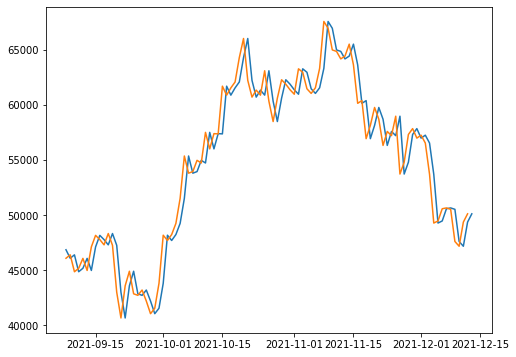

In [5]:
plt.figure(figsize=(8, 6))
plt.plot(df.Date[2500:], df['Closing Price (USD)'][2500:]);
plt.plot(df.Date[2500:-1], df['Closing Price (USD)'][2501:]);

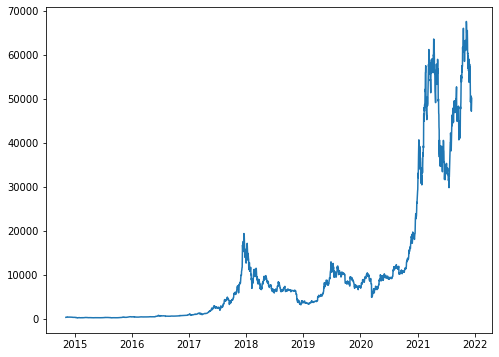

In [6]:
plt.figure(figsize=(8, 6))
plt.plot(df.Date, df['Closing Price (USD)']);

**Note:** Seasonality is num of samples, e.g. seasonality of daily means one sample per day

In [7]:
df2 = pd.read_csv('BTC_USD_2014-11-04_2021-12-13-CoinDesk.csv',
                 parse_dates=['Date'],
                 index_col=['Date'])

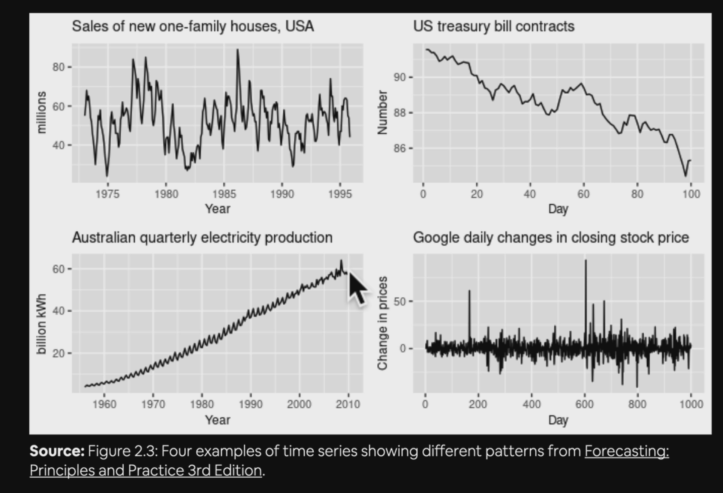

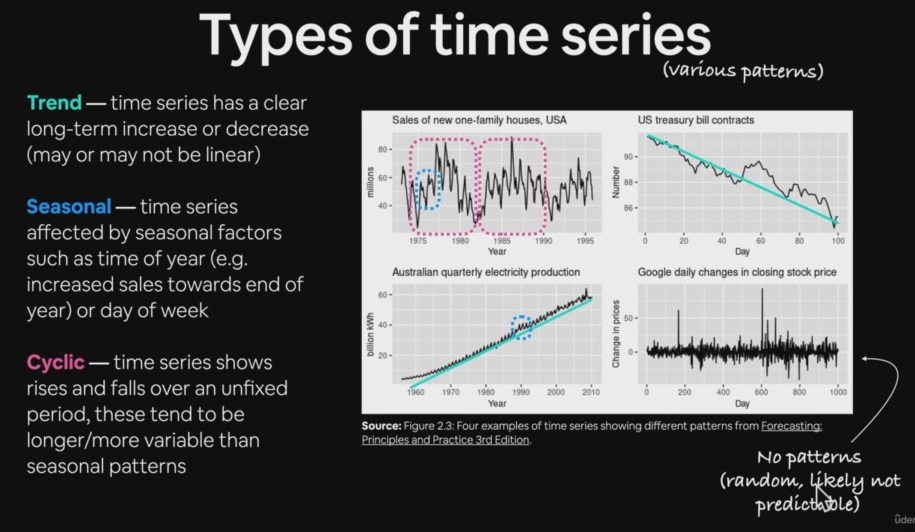

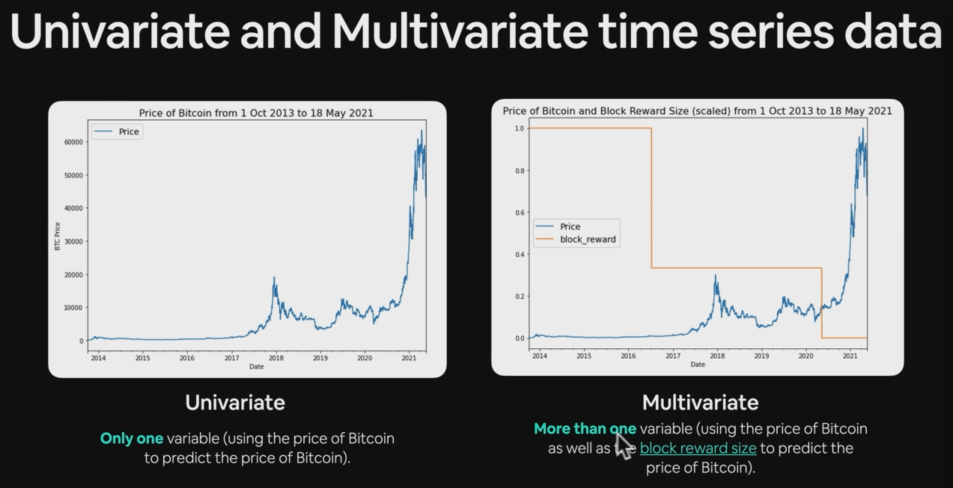

In [8]:
df2.head()

Currency  Closing Price (USD)  24h Open (USD)  24h High (USD)  \
Date                                                                       
2014-11-04      BTC           324.467934      323.826186      333.539527   
2014-11-05      BTC           328.644408      324.424164      330.671610   
2014-11-06      BTC           337.921358      328.653046      342.384170   
2014-11-07      BTC           348.992860      337.921358      352.585895   
2014-11-08      BTC           341.459753      348.992860      351.651854   

            24h Low (USD)  
Date                       
2014-11-04     323.106623  
2014-11-05     320.902900  
2014-11-06     328.597125  
2014-11-07     336.236830  
2014-11-08     340.196145

In [9]:
df2 = pd.DataFrame(df2['Closing Price (USD)']).rename(columns={'Closing Price (USD)':'Price'})

In [10]:
df2.head()

Price
Date                  
2014-11-04  324.467934
2014-11-05  328.644408
2014-11-06  337.921358
2014-11-07  348.992860
2014-11-08  341.459753

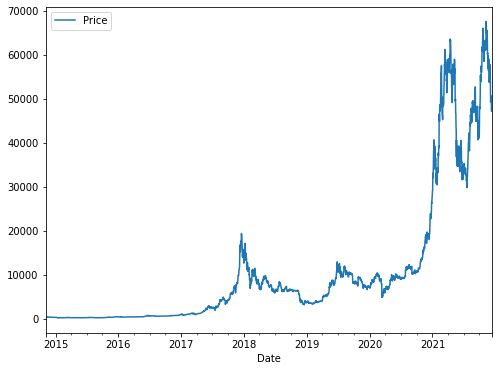

In [11]:
df2.plot(figsize=(8,6));

In [12]:
# Import the data using python csv
import csv
from datetime import datetime

time_steps = []
btc_price = []

with open('BTC_USD_2014-11-04_2021-12-13-CoinDesk.csv', mode='r') as f:
    file = csv.reader(f, delimiter=',')
    next(file) # skip the first row
    for line in file:
        time_steps.append(datetime.strptime(line[1], "%Y-%m-%d"))
        btc_price.append(float(line[2]))

In [13]:
time_steps[:5]

[datetime.datetime(2014, 11, 4, 0, 0),
 datetime.datetime(2014, 11, 5, 0, 0),
 datetime.datetime(2014, 11, 6, 0, 0),
 datetime.datetime(2014, 11, 7, 0, 0),
 datetime.datetime(2014, 11, 8, 0, 0)]

In [14]:
btc_price[:5]

[324.467934, 328.644408, 337.921358, 348.99286, 341.459753]

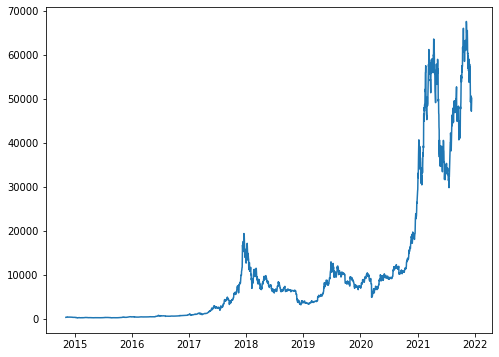

In [15]:
plt.figure(figsize=(8,6))
plt.plot(time_steps, btc_price);

### Train and Test Split

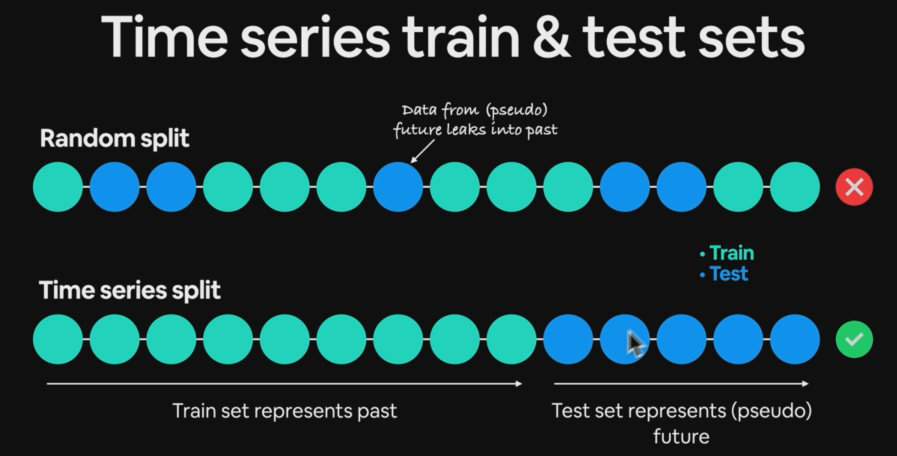

In [16]:
btc_price[:2]

[324.467934, 328.644408]

In [17]:
time_steps[:2]

[datetime.datetime(2014, 11, 4, 0, 0), datetime.datetime(2014, 11, 5, 0, 0)]

In [18]:
split_size = int(0.8 * len(time_steps))

X_train = time_steps[:split_size]
X_test = time_steps[split_size:]

y_train = btc_price[:split_size]
y_test = btc_price[split_size:]

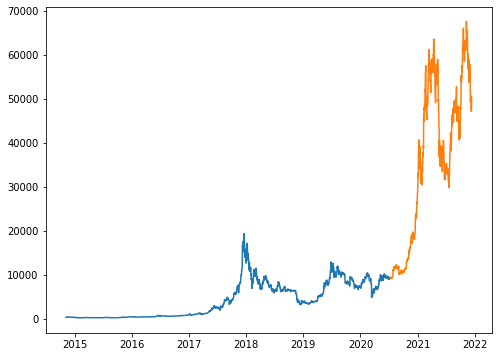

In [19]:
plt.figure(figsize=(8,6))
plt.plot(X_train, y_train)
plt.plot(X_test, y_test);

In [20]:
def plot_graph_zoomed(X, y, train_size=None, zoomed=False, start=None, end=None, label=None, figure=False, color=None, marker=None, markersize=None):
    
    if zoomed == False:
        split_size = int(train_size * len(X))

        X_train = X[:split_size]
        X_test = X[split_size:]

        y_train = y[:split_size]
        y_test = y[split_size:]
        
        if train_size == 1:
            if figure == True:
                plt.figure(figsize=(8,6))
                plt.plot(X_train, y_train, label=label, color=color, marker=marker, markersize=markersize)
                plt.plot(X_test, y_test, color=color)
                plt.xlabel('Date', fontsize=12)
                plt.ylabel('Price', fontsize=12)
                plt.legend();
            else:
                plt.plot(X_train, y_train, label=label, color=color, marker=marker, markersize=markersize)
                plt.plot(X_test, y_test, color=color)
                plt.xlabel('Date', fontsize=12)
                plt.ylabel('Price', fontsize=12)
                plt.legend();
                
        else:
            if figure == True:
                plt.figure(figsize=(8,6))
                plt.plot(X_train, y_train, label=label, marker=marker, markersize=markersize)
                plt.plot(X_test, y_test, label=label, marker=marker, markersize=markersize)
                plt.xlabel('Date', fontsize=12)
                plt.ylabel('Price', fontsize=12)
                plt.legend();
            else:
                plt.plot(X_train, y_train, label=label, marker=marker, markersize=markersize)
                plt.plot(X_test, y_test, label=label, marker=marker, markersize=markersize)
                plt.xlabel('Date', fontsize=12)
                plt.ylabel('Price', fontsize=12)
                plt.legend();
            
            
    
    elif zoomed == True:

        X = X[start:end]

        y = y[start:end]

        plt.plot(X, y, label=label, marker=marker, markersize=markersize)
        plt.xlabel('Date', fontsize=12)
        plt.ylabel('Price', fontsize=12)
        plt.legend();
        

No handles with labels found to put in legend.


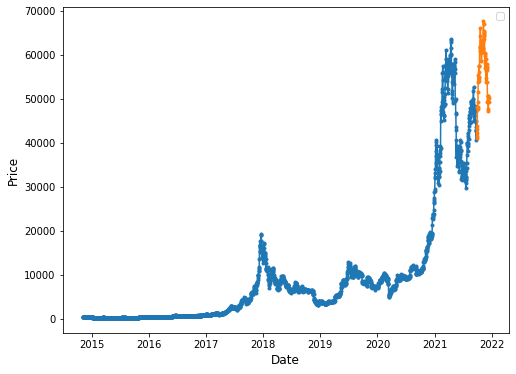

In [21]:
plot_graph_zoomed(time_steps, btc_price, train_size=0.97, figure=True, marker='o', markersize=3)

## Modelling Experiments

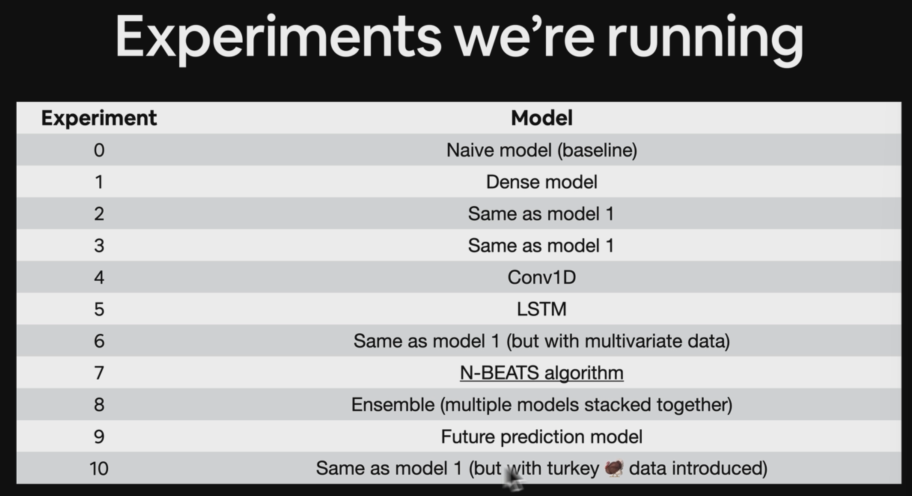

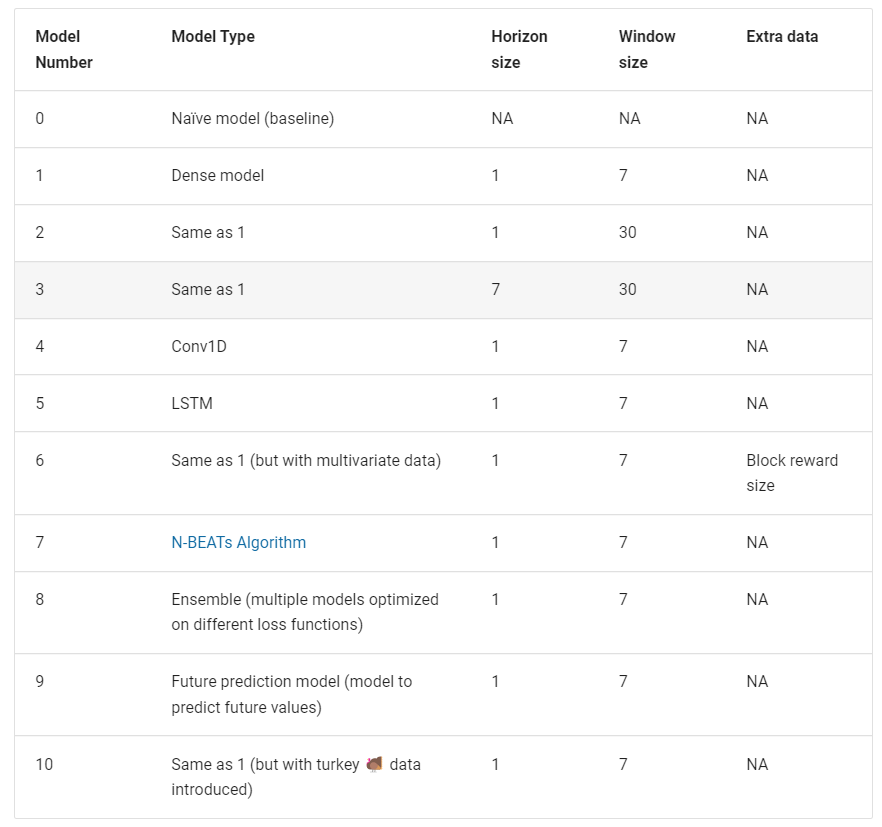

**Note:** 
> **Horizon:** = number of timesteps into the future we're going to predict

> **Window Size:** = number of timesteps we're going to use to predict horizon

### Model 0: Naive Forecast

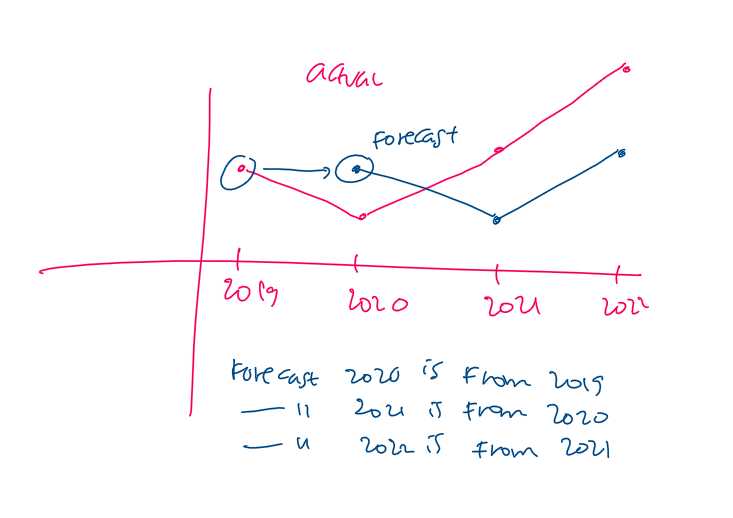

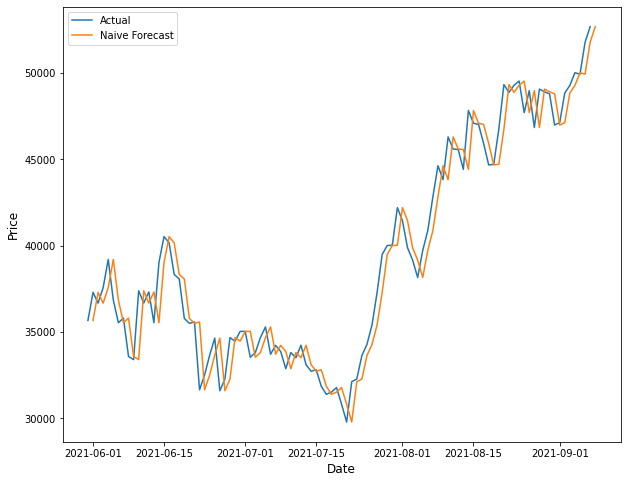

In [22]:
plt.figure(figsize=(10, 8))
plot_graph_zoomed(time_steps, btc_price, zoomed=True,
                  start=2400, end=2500, label='Actual')
plot_graph_zoomed(time_steps[1:], btc_price[:-1],
                  zoomed=True, start=2400, end=2500, label='Naive Forecast')

## Evaluating Metrics

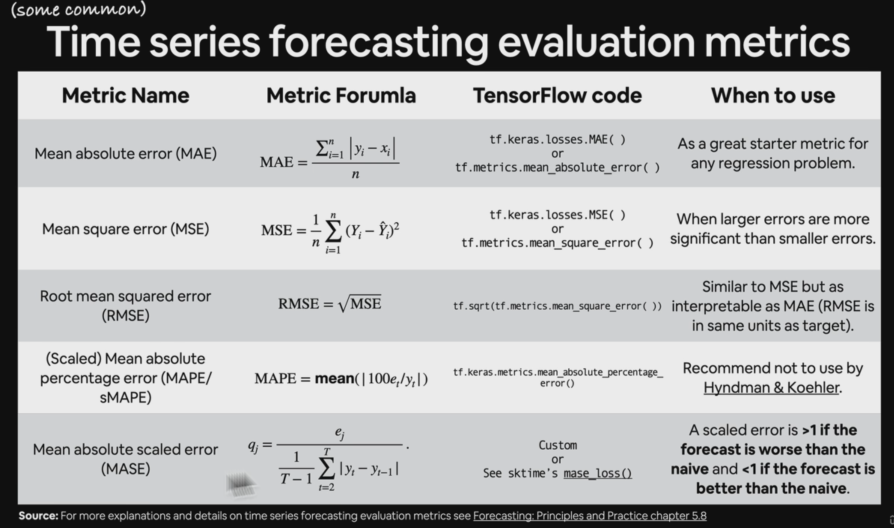

In [23]:
from sklearn.metrics import mean_absolute_error, r2_score

In [62]:
# Error Rate
print(mean_absolute_error(btc_price[1:], btc_price[:-1]))
print(r2_score(btc_price[1:], btc_price[:-1]))
print(tf.metrics.mean_absolute_percentage_error(btc_price[1:], btc_price[:-1]))

319.62824370146376
0.9975701334721688
tf.Tensor(2.629358, shape=(), dtype=float32)


In [63]:
btc_price[1:5] # Actual

[328.644408, 337.921358, 348.99286, 341.459753]

In [64]:
btc_price[:5-1] # Naive Forecast

[324.467934, 328.644408, 337.921358, 348.99286]

In [65]:
act = btc_price[1:]
naive = btc_price[:-1]

In [66]:
def mape(y_true, y_pred):
    perc_error = []
    for i in range(len(y_true)):
        error = np.absolute((y_true[i] - y_pred[i]) / y_pred[i] * 100)
        perc_error.append(error)
    
    return np.mean(perc_error)

In [67]:
mape(y_true=act, y_pred=naive)

2.6260392924816354

In [68]:
# MASE Implementation
def mase(y_true, y_pred):
    """
    Implement MASE (assuming no seasonality)
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    mae = np.mean(np.abs(y_true - y_pred))
    
    # Naive forecast
    mae_naive = np.mean(np.abs(y_true[1:] - y_true[:-1]))
    
    # Let's assume mae naive is 300, and mae normal is 450, so 
    # mae naive is better than naive normal
    # >1 mae naive better, <1 mae normal is better
    
    return mae / mae_naive

In [69]:
mase(y_true=act, y_pred=naive)

0.9996198234567235

In [70]:
def evaluate_preds(y_true, y_pred):
    
    y_true = np.array(y_true, dtype=np.float32)
    y_pred = np.array(y_pred, dtype=np.float32)
    
    mae = np.mean(np.abs(y_true - y_pred))
    mse = np.mean(np.square(y_true - y_pred))
    rmse = np.sqrt(np.mean(np.square(y_true - y_pred)))
    _mape = mape(y_true, y_pred)
    _mase = mase(y_true, y_pred)
    
    dicts = {'MAE':mae, 
             'MSE':mse,
             'RMSE':rmse,
             'MAPE':_mape,
             'MASE':_mase}
    
    return dicts

In [71]:
evaluate_preds(act, naive)

{'MAE': 319.62827,
 'MSE': 585325.44,
 'RMSE': 765.0656,
 'MAPE': 2.6260393424691437,
 'MASE': 0.99961984}

In [72]:
tf.constant([1., 2., 3.])

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([1., 2., 3.], dtype=float32)>

In [73]:
np.array(tf.constant([1., 2., 3.]))

array([1., 2., 3.], dtype=float32)

## Other models

In [74]:
df_rol = pd.read_csv('BTC_USD_2014-11-04_2021-12-13-CoinDesk.csv', parse_dates=['Date'])
df_rol.head()

Currency       Date  Closing Price (USD)  24h Open (USD)  24h High (USD)  \
0      BTC 2014-11-04           324.467934      323.826186      333.539527   
1      BTC 2014-11-05           328.644408      324.424164      330.671610   
2      BTC 2014-11-06           337.921358      328.653046      342.384170   
3      BTC 2014-11-07           348.992860      337.921358      352.585895   
4      BTC 2014-11-08           341.459753      348.992860      351.651854   

   24h Low (USD)  
0     323.106623  
1     320.902900  
2     328.597125  
3     336.236830  
4     340.196145

In [75]:
df_rol.columns

Index(['Currency', 'Date', 'Closing Price (USD)', '24h Open (USD)',
       '24h High (USD)', '24h Low (USD)'],
      dtype='object')

In [76]:
df_rol = df_rol[['Date', 'Closing Price (USD)']]
df_rol.head()

Date  Closing Price (USD)
0 2014-11-04           324.467934
1 2014-11-05           328.644408
2 2014-11-06           337.921358
3 2014-11-07           348.992860
4 2014-11-08           341.459753

In [77]:
df_rolling = df_rol.rolling(window=3).mean()

In [78]:
df_rolling.head()

Closing Price (USD)
0                  NaN
1                  NaN
2           330.344567
3           338.519542
4           342.791324

In [79]:
df_rolling.isnull().sum()

Closing Price (USD)    2
dtype: int64

In [80]:
roll = df_rolling['Closing Price (USD)'].tolist()
roll[:5]

[nan, nan, 330.34456666666665, 338.519542, 342.79132366666664]

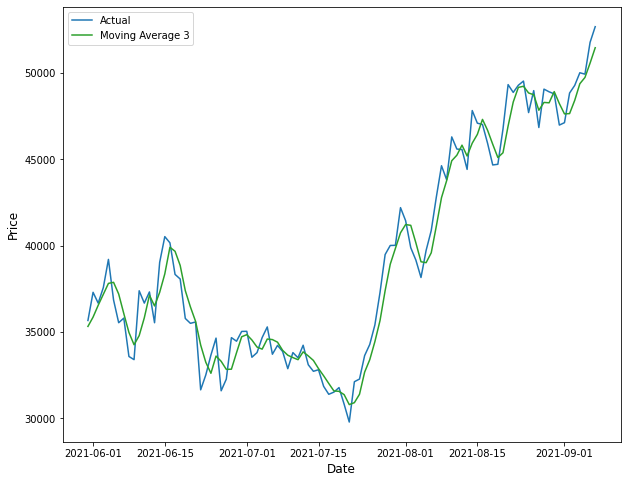

In [81]:
plt.figure(figsize=(10, 8))
plot_graph_zoomed(time_steps[2400:2500], btc_price[2400:2500], train_size=1, label='Actual')
plot_graph_zoomed(time_steps[2400:2500], roll[2400:2500], train_size=1, label='Moving Average 3')

## Windowing Our Datasets

Why do we window?

We window our time series dataset to turn out our data into a supervised learning problem.

```
Windowing one week
[0, 1, 2, 3, 4, 5, 6] --> [7]
[1, 2, 3, 4, 5, 6, 7] --> [8]
[2, 3, 4, 5, 6, 7, 8] --> [9]
```


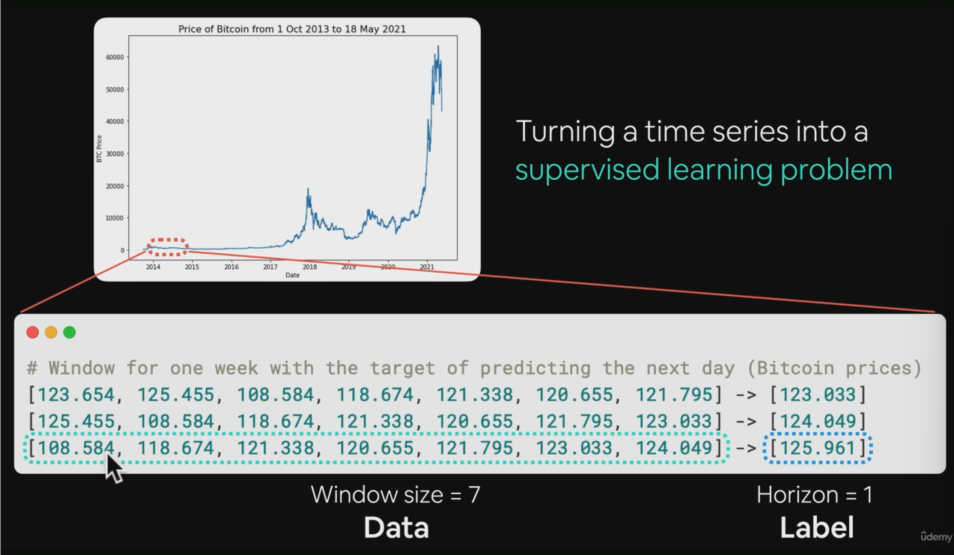

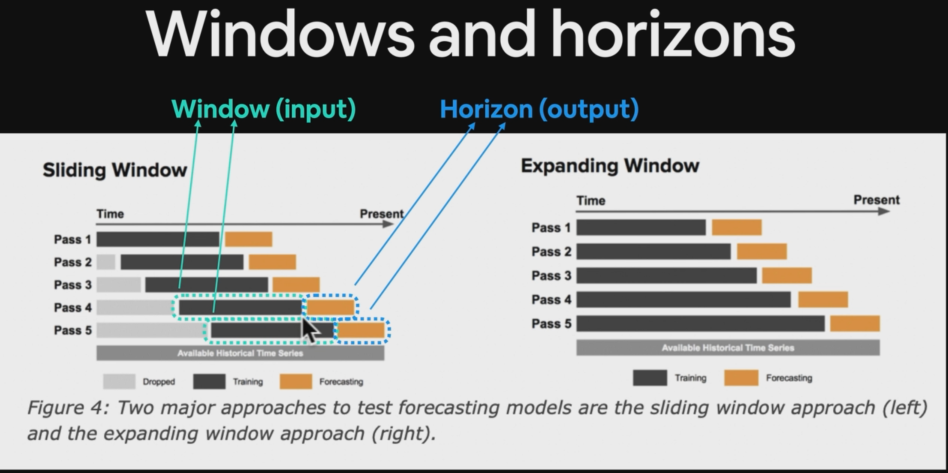

In [82]:
df.head()

Currency       Date  Closing Price (USD)  24h Open (USD)  24h High (USD)  \
0      BTC 2014-11-04           324.467934      323.826186      333.539527   
1      BTC 2014-11-05           328.644408      324.424164      330.671610   
2      BTC 2014-11-06           337.921358      328.653046      342.384170   
3      BTC 2014-11-07           348.992860      337.921358      352.585895   
4      BTC 2014-11-08           341.459753      348.992860      351.651854   

   24h Low (USD)  
0     323.106623  
1     320.902900  
2     328.597125  
3     336.236830  
4     340.196145

In [83]:
len(y_train)

2077

In [84]:
y_train[:7]

[324.467934,
 328.644408,
 337.921358,
 348.99286,
 341.459753,
 344.745289,
 357.239982]

In [85]:
y_train[7]

371.116917

In [86]:
# Set window size and horizon
WINDOW_SIZE = 7 
HORIZON = 1

In [87]:
def get_labelled_window(x, horizon=HORIZON):
    """
    Creates labels for windowed dataset
    
    E.g. if horizon=1
    Input: [0, 1, 2, 3, 4, 5, 6, 7] -> Output: ([0, 1, 2, 3, 4, 5, 6], [7])
    """
    
    return x[:, :-horizon], x[:, -horizon:]

In [88]:
test_window, test_label = get_labelled_window(np.expand_dims(np.arange(8), axis=0))

In [89]:
test_window

array([[0, 1, 2, 3, 4, 5, 6]])

In [90]:
test_label

array([[7]])

### Get horizon and window size

In [91]:
btc_price[:10]

[324.467934,
 328.644408,
 337.921358,
 348.99286,
 341.459753,
 344.745289,
 357.239982,
 371.116917,
 366.664633,
 428.882925]

In [92]:
def make_windows(x, window_size=WINDOW_SIZE, horizon=HORIZON):
    
    # 1. Create a window of specific window_size
    # (add  the horizon on the end for labelling later)
    window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
    
    # 2. Create a 2D array of multiple steps
    window_indexes = window_step + np.expand_dims(np.arange(len(x) - (window_size+horizon-1)), axis=0).T
    
    # 3. Index on the target array
    windowed_array = x[window_indexes]
    
    # 4. Get the labelled window
    windows, labels = get_labelled_window(windowed_array, horizon=horizon)
    
    return windows, labels

In [93]:
full_windows, full_labels = make_windows(np.array(btc_price), window_size=WINDOW_SIZE, horizon=HORIZON)

In [94]:
full_windows[0], full_labels[0], full_windows[1], full_labels[1]

(array([324.467934, 328.644408, 337.921358, 348.99286 , 341.459753,
        344.745289, 357.239982]),
 array([371.116917]),
 array([328.644408, 337.921358, 348.99286 , 341.459753, 344.745289,
        357.239982, 371.116917]),
 array([366.664633]))

In [95]:
len(full_windows)

2590

### Trying

In [96]:
c = np.expand_dims(np.arange(WINDOW_SIZE+HORIZON), axis=0)
d = np.expand_dims(np.arange(20 - (WINDOW_SIZE+HORIZON-1)), axis=0).T

In [97]:
c

array([[0, 1, 2, 3, 4, 5, 6, 7]])

In [98]:
d

array([[ 0],
       [ 1],
       [ 2],
       [ 3],
       [ 4],
       [ 5],
       [ 6],
       [ 7],
       [ 8],
       [ 9],
       [10],
       [11],
       [12]])

In [99]:
c + d

array([[ 0,  1,  2,  3,  4,  5,  6,  7],
       [ 1,  2,  3,  4,  5,  6,  7,  8],
       [ 2,  3,  4,  5,  6,  7,  8,  9],
       [ 3,  4,  5,  6,  7,  8,  9, 10],
       [ 4,  5,  6,  7,  8,  9, 10, 11],
       [ 5,  6,  7,  8,  9, 10, 11, 12],
       [ 6,  7,  8,  9, 10, 11, 12, 13],
       [ 7,  8,  9, 10, 11, 12, 13, 14],
       [ 8,  9, 10, 11, 12, 13, 14, 15],
       [ 9, 10, 11, 12, 13, 14, 15, 16],
       [10, 11, 12, 13, 14, 15, 16, 17],
       [11, 12, 13, 14, 15, 16, 17, 18],
       [12, 13, 14, 15, 16, 17, 18, 19]])

In [100]:
(np.arange(20)*100)[c+d]

array([[   0,  100,  200,  300,  400,  500,  600,  700],
       [ 100,  200,  300,  400,  500,  600,  700,  800],
       [ 200,  300,  400,  500,  600,  700,  800,  900],
       [ 300,  400,  500,  600,  700,  800,  900, 1000],
       [ 400,  500,  600,  700,  800,  900, 1000, 1100],
       [ 500,  600,  700,  800,  900, 1000, 1100, 1200],
       [ 600,  700,  800,  900, 1000, 1100, 1200, 1300],
       [ 700,  800,  900, 1000, 1100, 1200, 1300, 1400],
       [ 800,  900, 1000, 1100, 1200, 1300, 1400, 1500],
       [ 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600],
       [1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700],
       [1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800],
       [1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900]])

In [101]:
e = np.array([[0, 1, 2, 3, 4],
              [1, 2, 3, 4, 5]])
e

array([[0, 1, 2, 3, 4],
       [1, 2, 3, 4, 5]])

In [102]:
np.arange(6)*100

array([  0, 100, 200, 300, 400, 500])

In [103]:
(np.arange(6)*100)[e]

array([[  0, 100, 200, 300, 400],
       [100, 200, 300, 400, 500]])

## Split the data

In [104]:
full_windows

array([[  324.467934,   328.644408,   337.921358, ...,   341.459753,
          344.745289,   357.239982],
       [  328.644408,   337.921358,   348.99286 , ...,   344.745289,
          357.239982,   371.116917],
       [  337.921358,   348.99286 ,   341.459753, ...,   357.239982,
          371.116917,   366.664633],
       ...,
       [53694.69    , 49266.12    , 49455.282036, ..., 50638.162863,
        50512.038512, 47594.381934],
       [49266.12    , 49455.282036, 50564.3     , ..., 50512.038512,
        47594.381934, 47162.32405 ],
       [49455.282036, 50564.3     , 50638.162863, ..., 47594.381934,
        47162.32405 , 49353.419314]])

In [105]:
full_labels

array([[  371.116917],
       [  366.664633],
       [  428.882925],
       ...,
       [47162.32405 ],
       [49353.419314],
       [50103.541821]])

In [106]:
def make_train_test_split(windows, labels, test_split=0.2):
    train_split = 1 - test_split
    final_index = int(train_split * len(windows))
    
    train_windows = windows[:final_index]
    test_windows = windows[final_index:]
    
    train_labels = labels[:final_index]
    test_labels = labels[final_index:]
    
    return train_windows, test_windows, train_labels, test_labels

In [107]:
train_windows, test_windows, train_labels, test_labels = make_train_test_split(full_windows, full_labels, test_split=0.2)

In [108]:
len(train_windows), len(test_windows)

(2072, 518)

In [109]:
len(train_labels), len(test_labels)

(2072, 518)

## Creating Checkpoint

In [110]:
def make_checkpoint(filepath):
    return tf.keras.callbacks.ModelCheckpoint(filepath='BTC_Model/'+filepath,
                                              monitor='val_loss',
                                              verbose=1,
                                              save_best_only=True,
                                              save_weights_only=False)

## Creating Model 1

**`Dense model, windows=7, horizon=1`**

In [111]:
train_windows.shape

(2072, 7)

In [112]:
# Set inputs
inputs = layers.Input(shape=(7))

# Pass the inputs to dense layer
x = layers.Dense(256, activation='relu')(inputs)
outputs = layers.Dense(1, activation='linear')(x) # linear activation is the same as having no activation

# Pass inputs and outputs to model
model_1 = tf.keras.Model(inputs, outputs)

In [113]:
# Compile the model
model_1.compile(optimizer='adam',
                loss='mae')

In [77]:
# Fit the model
hist_1 = model_1.fit(train_windows, train_labels,
                     batch_size=128,
                     validation_data=(test_windows, test_labels),
                     epochs=100,
                     callbacks=make_checkpoint('model_1'))

Epoch 1/100
 9/17 [==============>...............] - ETA: 0s - loss: 397.8637
Epoch 00001: val_loss improved from inf to 2691.49487, saving model to BTC_Model\model_1
INFO:tensorflow:Assets written to: BTC_Model\model_1\assets
17/17 [==============================] - 1s 52ms/step - loss: 358.1502 - val_loss: 2691.4949
Epoch 2/100
10/17 [================>.............] - ETA: 0s - loss: 274.9720
Epoch 00002: val_loss improved from 2691.49487 to 1740.91687, saving model to BTC_Model\model_1
INFO:tensorflow:Assets written to: BTC_Model\model_1\assets
17/17 [==============================] - 1s 56ms/step - loss: 259.4234 - val_loss: 1740.9169
Epoch 3/100
11/17 [==================>...........] - ETA: 0s - loss: 208.5795
Epoch 00003: val_loss improved from 1740.91687 to 1685.73230, saving model to BTC_Model\model_1
INFO:tensorflow:Assets written to: BTC_Model\model_1\assets
17/17 [==============================] - 1s 49ms/step - loss: 209.7522 - val_loss: 1685.7323
Epoch 4/100
16/17 [=======

In [114]:
model_1 = load_model('BTC_Model/model_1/')

In [115]:
model_1.evaluate(test_windows, test_labels)

17/17 [==============================] - 0s 2ms/step - loss: 1077.9407


1077.940673828125

In [116]:
# Naive results
act = test_labels[1:]
naive = test_labels[:-1]

In [117]:
naive_results = evaluate_preds(y_true=act,
                               y_pred=naive)

In [118]:
naive_results

{'MAE': 1080.4816,
 'MSE': 2616088.8,
 'RMSE': 1617.4327,
 'MAPE': 2.8337994,
 'MASE': 0.99809825}

In [119]:
model_1_pred = model_1.predict(test_windows)

In [120]:
model_1_result = evaluate_preds(test_labels, model_1_pred)

In [121]:
model_1_result

{'MAE': 1077.9407,
 'MSE': 2622120.8,
 'RMSE': 1619.2964,
 'MAPE': 2.816699,
 'MASE': 0.99764836}

In [122]:
len(model_1_pred)

518

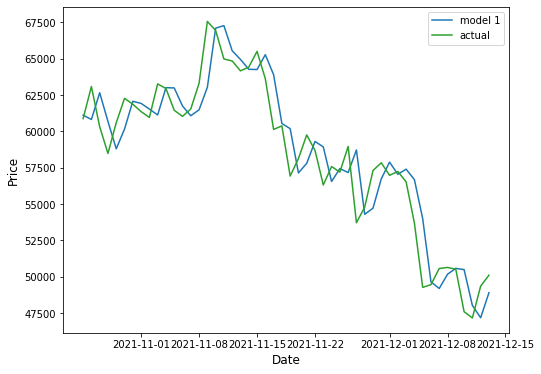

In [123]:
plt.figure(figsize=(8, 6))
plot_graph_zoomed(time_steps[-50:], model_1_pred[-50:], train_size=1, label='model 1')
plot_graph_zoomed(time_steps[-50:], test_labels[-50:], train_size=1, label='actual')

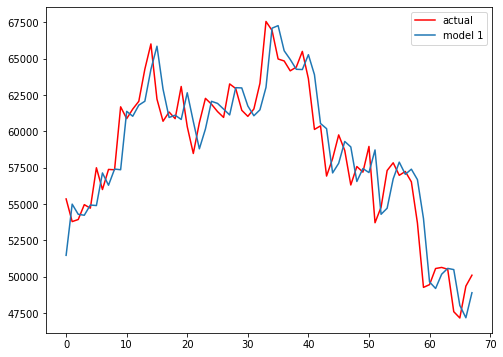

In [124]:
plt.figure(figsize=(8, 6))
plt.plot(test_labels[450:], label='actual', color='red')
plt.plot(model_1_pred[450:], label='model 1')
plt.legend();

## Model 2: Windows=30, Horizon=1

In [125]:
full_windows_30, full_labels_30 = make_windows(np.array(btc_price), window_size=30, horizon=1)

In [126]:
train_windows_30, test_windows_30, train_labels_30, test_labels_30 = make_train_test_split(full_windows_30, full_labels_30)

In [127]:
train_windows_30[0], train_windows_30[1]

(array([324.467934, 328.644408, 337.921358, 348.99286 , 341.459753,
        344.745289, 357.239982, 371.116917, 366.664633, 428.882925,
        418.944218, 399.688315, 374.983975, 388.040069, 387.062731,
        373.7797  , 378.013084, 356.750538, 350.599464, 352.080105,
        366.424325, 376.211826, 376.917086, 369.402421, 369.807768,
        377.078294, 375.964613, 377.568288, 380.535819, 382.810282]),
 array([328.644408, 337.921358, 348.99286 , 341.459753, 344.745289,
        357.239982, 371.116917, 366.664633, 428.882925, 418.944218,
        399.688315, 374.983975, 388.040069, 387.062731, 373.7797  ,
        378.013084, 356.750538, 350.599464, 352.080105, 366.424325,
        376.211826, 376.917086, 369.402421, 369.807768, 377.078294,
        375.964613, 377.568288, 380.535819, 382.810282, 376.230628]))

In [128]:
train_labels_30[0]

array([376.230628])

In [129]:
train_windows_30.shape

(2053, 30)

In [130]:
# Create inputs
inputs = layers.Input(shape=(30))

# Pass the inputs to the dense layer
x = layers.Dense(128, activation='relu')(inputs)
outputs = layers.Dense(1)(x)

# Pass the inputs and outputs to the model
model_2 = tf.keras.Model(inputs, outputs)

In [92]:
# Compile the model
model_2.compile(optimizer=Adam(),
                loss='mae')

In [94]:
# Fit the model
hist_2 = model_2.fit(train_windows_30, train_labels_30,
                     epochs=100,
                     validation_data=(test_windows_30, test_labels_30),
                     callbacks=make_checkpoint('model_2'))

Epoch 1/100
60/65 [==========================>...] - ETA: 0s - loss: 210.5164
Epoch 00001: val_loss improved from inf to 2268.32031, saving model to BTC_Model\model_2
INFO:tensorflow:Assets written to: BTC_Model\model_2\assets
65/65 [==============================] - 1s 18ms/step - loss: 209.5405 - val_loss: 2268.3203
Epoch 2/100
56/65 [========================>.....] - ETA: 0s - loss: 203.0737
Epoch 00002: val_loss improved from 2268.32031 to 1552.19971, saving model to BTC_Model\model_2
INFO:tensorflow:Assets written to: BTC_Model\model_2\assets
65/65 [==============================] - 1s 15ms/step - loss: 204.9114 - val_loss: 1552.1997
Epoch 3/100
61/65 [===========================>..] - ETA: 0s - loss: 196.4101
Epoch 00003: val_loss improved from 1552.19971 to 1404.27026, saving model to BTC_Model\model_2
INFO:tensorflow:Assets written to: BTC_Model\model_2\assets
65/65 [==============================] - 1s 16ms/step - loss: 195.9045 - val_loss: 1404.2703
Epoch 4/100
65/65 [=======

In [131]:
model_2 = load_model('BTC_Model/model_2/')
model_2.evaluate(test_windows_30, test_labels_30)

17/17 [==============================] - 0s 2ms/step - loss: 1110.8635


1110.863525390625

In [132]:
model_2_pred = model_2.predict(test_windows_30)

In [133]:
model_2_results = evaluate_preds(test_labels_30, model_2_pred)

In [134]:
model_2_results

{'MAE': 1110.8638,
 'MSE': 2700629.2,
 'RMSE': 1643.3591,
 'MAPE': 2.861853,
 'MASE': 1.020469}

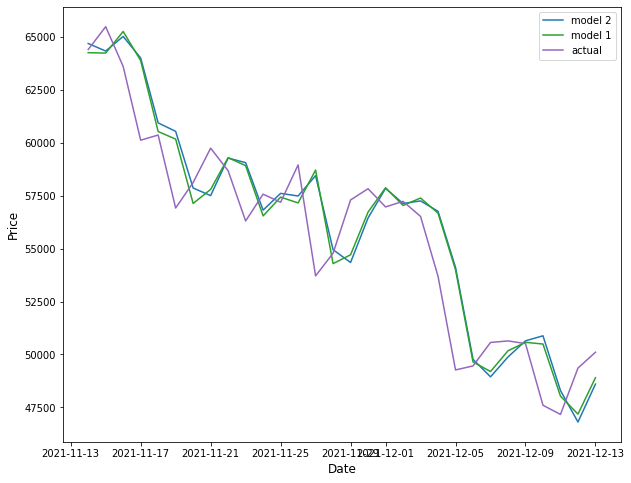

In [135]:
plt.figure(figsize=(10, 8))
plot_graph_zoomed(time_steps[-30:], model_2_pred[-30:], train_size=1, label='model 2')
plot_graph_zoomed(time_steps[-30:], model_1_pred[-30:], train_size=1, label='model 1')
plot_graph_zoomed(time_steps[-30:], test_labels_30[-30:], train_size=1, label='actual')

## Model 3: Windows=30, Horizons=7

In [136]:
full_windows_307, full_labels_307 = make_windows(np.array(btc_price),
                                               window_size=30,
                                               horizon=7)
train_windows_307, test_windows_307, train_labels_307, test_labels_307 = make_train_test_split(full_windows_307, full_labels_307)

In [137]:
train_windows_307[0]

array([324.467934, 328.644408, 337.921358, 348.99286 , 341.459753,
       344.745289, 357.239982, 371.116917, 366.664633, 428.882925,
       418.944218, 399.688315, 374.983975, 388.040069, 387.062731,
       373.7797  , 378.013084, 356.750538, 350.599464, 352.080105,
       366.424325, 376.211826, 376.917086, 369.402421, 369.807768,
       377.078294, 375.964613, 377.568288, 380.535819, 382.810282])

In [138]:
train_labels_307[0]

array([376.230628, 370.539639, 377.384886, 375.097528, 375.749288,
       361.12719 , 351.69696 ])

In [139]:
# Create inputs
inputs = layers.Input(shape=(30))

# Pass the inputs to the dense layer
x = layers.Dense(128, activation='relu')(inputs)
outputs = layers.Dense(7)(x)

# Pass the inputs and outputs to the model
model_3 = tf.keras.Model(inputs, outputs)

# Compile the model
model_3.compile(optimizer=Adam(),
                loss='mae')

In [106]:
# Fit the model
hist_3 = model_3.fit(train_windows_307, train_labels_307,
                     epochs=100,
                     validation_data=(test_windows_307, test_labels_307),
                     callbacks=make_checkpoint('model_3'))

Epoch 1/100
52/64 [=======================>......] - ETA: 0s - loss: 1091.0896
Epoch 00001: val_loss improved from inf to 4167.27832, saving model to BTC_Model\model_3
INFO:tensorflow:Assets written to: BTC_Model\model_3\assets
64/64 [==============================] - 1s 17ms/step - loss: 981.5193 - val_loss: 4167.2783
Epoch 2/100
50/64 [======================>.......] - ETA: 0s - loss: 478.8079
Epoch 00002: val_loss improved from 4167.27832 to 3433.47754, saving model to BTC_Model\model_3
INFO:tensorflow:Assets written to: BTC_Model\model_3\assets
64/64 [==============================] - 1s 10ms/step - loss: 462.0149 - val_loss: 3433.4775
Epoch 3/100
56/64 [=========================>....] - ETA: 0s - loss: 398.2342
Epoch 00003: val_loss improved from 3433.47754 to 2970.84399, saving model to BTC_Model\model_3
INFO:tensorflow:Assets written to: BTC_Model\model_3\assets
64/64 [==============================] - 1s 9ms/step - loss: 393.6609 - val_loss: 2970.8440
Epoch 4/100
54/64 [=======

In [140]:
model_3 = load_model('BTC_Model/model_3/')
model_3.evaluate(test_windows_307, test_labels_307)

17/17 [==============================] - 0s 2ms/step - loss: 2230.2888


2230.288818359375

In [141]:
model_3_pred = model_3.predict(test_windows_307)

In [142]:
model_3_results = evaluate_preds(test_labels_307, model_3_pred)

In [143]:
model_3_pred[0], test_labels_307[0]

(array([9242.055, 9499.874, 9368.749, 9178.185, 9202.453, 9193.396,
        9094.726], dtype=float32),
 array([9299.538653, 9236.91    , 9255.128114, 9191.484156, 9130.44172 ,
        9154.163861, 9174.642023]))

In [144]:
model_3_results

{'MAE': 2230.2888,
 'MSE': 10878741.0,
 'RMSE': 3298.2937,
 'MAPE': 5.9005966,
 'MASE': 2.0583045}

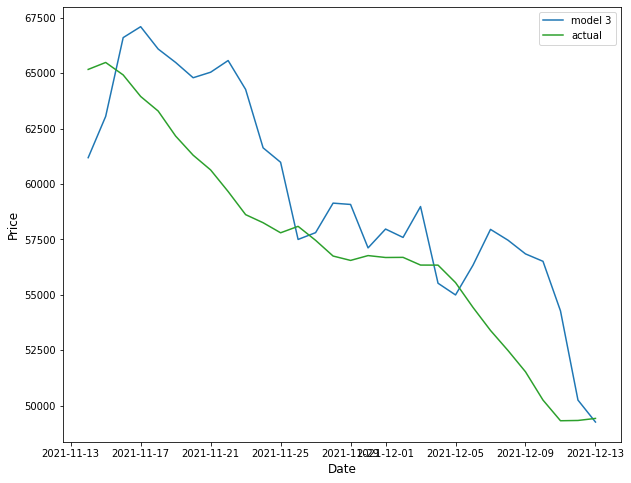

In [145]:
plt.figure(figsize=(10, 8))
plot_graph_zoomed(time_steps[-30:], np.mean(model_3_pred, axis=1)[-30:], train_size=1, label='model 3')
plot_graph_zoomed(time_steps[-30:], np.mean(test_labels_307, axis=1)[-30:], train_size=1, label='actual')

## Model 3b: Windows=3, Horizon=1

In [146]:
full_windows_31, full_labels_31 = make_windows(np.array(btc_price),
                                               window_size=3,
                                               horizon=1)
train_windows_31, test_windows_31, train_labels_31, test_labels_31 = make_train_test_split(full_windows_31, full_labels_31)

In [147]:
train_windows_31[0], train_windows_31[1]

(array([324.467934, 328.644408, 337.921358]),
 array([328.644408, 337.921358, 348.99286 ]))

In [148]:
train_labels_31[0]

array([348.99286])

In [149]:
# Create inputs
inputs = layers.Input(shape=(3))

# Pass the inputs to the dense layer
x = layers.Dense(256, activation='relu')(inputs)
outputs = layers.Dense(1)(x)

# Pass the inputs and outputs to the model
model_3b = tf.keras.Model(inputs, outputs)

# Compile the model
model_3b.compile(optimizer=Adam(),
                loss='mae')

In [117]:
# Fit the model
hist_3b = model_3b.fit(train_windows_31, train_labels_31,
                     epochs=100,
                     validation_data=(test_windows_31, test_labels_31),
                     callbacks=make_checkpoint('model_3b'))

Epoch 1/100
60/65 [==========================>...] - ETA: 0s - loss: 653.8353
Epoch 00001: val_loss improved from inf to 1380.31714, saving model to BTC_Model\model_3b
INFO:tensorflow:Assets written to: BTC_Model\model_3b\assets
65/65 [==============================] - 1s 14ms/step - loss: 618.8121 - val_loss: 1380.3171
Epoch 2/100
61/65 [===========================>..] - ETA: 0s - loss: 156.6111
Epoch 00002: val_loss improved from 1380.31714 to 1239.24756, saving model to BTC_Model\model_3b
INFO:tensorflow:Assets written to: BTC_Model\model_3b\assets
65/65 [==============================] - 1s 14ms/step - loss: 155.4928 - val_loss: 1239.2476
Epoch 3/100
54/65 [=======================>......] - ETA: 0s - loss: 153.3873
Epoch 00003: val_loss did not improve from 1239.24756
65/65 [==============================] - 0s 4ms/step - loss: 150.6945 - val_loss: 1242.4657
Epoch 4/100
62/65 [===========================>..] - ETA: 0s - loss: 146.7743
Epoch 00004: val_loss improved from 1239.24756 

In [150]:
model_3b = load_model('BTC_Model/model_3b/')
model_3b.evaluate(test_windows_31, test_labels_31)

17/17 [==============================] - 0s 2ms/step - loss: 1072.5980


1072.5980224609375

In [151]:
model_3b_pred = model_3b.predict(test_windows_31)
model_3b_results = evaluate_preds(test_labels_31, model_3b_pred)
model_3b_results

{'MAE': 1072.5979,
 'MSE': 2602797.5,
 'RMSE': 1613.3187,
 'MAPE': 2.7951777,
 'MASE': 0.9945122}

In [152]:
model_1_result, model_2_results, naive_results

({'MAE': 1077.9407,
  'MSE': 2622120.8,
  'RMSE': 1619.2964,
  'MAPE': 2.816699,
  'MASE': 0.99764836},
 {'MAE': 1110.8638,
  'MSE': 2700629.2,
  'RMSE': 1643.3591,
  'MAPE': 2.861853,
  'MASE': 1.020469},
 {'MAE': 1080.4816,
  'MSE': 2616088.8,
  'RMSE': 1617.4327,
  'MAPE': 2.8337994,
  'MASE': 0.99809825})

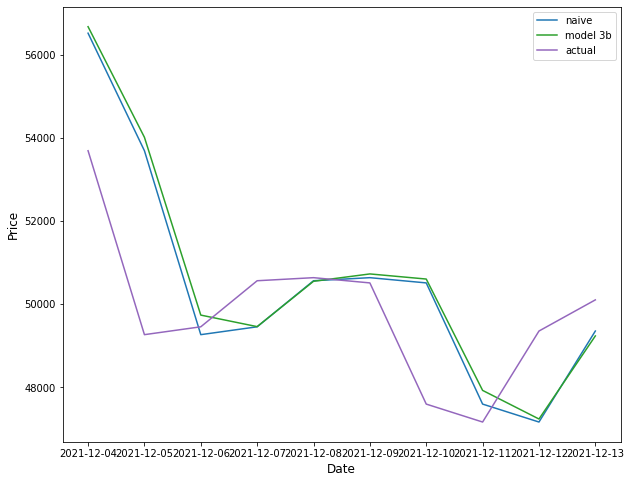

In [153]:
plt.figure(figsize=(10, 8))
plot_graph_zoomed(time_steps[-10:], naive[-10:], train_size=1, label='naive')
# plot_graph_zoomed(time_steps[-10:], model_1_pred[-10:], train_size=1, label='model 1')
# plot_graph_zoomed(time_steps[-10:], model_2_pred[-10:], train_size=1, label='model 2')
# plot_graph_zoomed(time_steps[-10:], model_3_pred[-10:, 0], train_size=1, label='model 3')
plot_graph_zoomed(time_steps[-10:], model_3b_pred[-10:], train_size=1, label='model 3b')
plot_graph_zoomed(time_steps[-10:], test_labels_31[-10:], train_size=1, label='actual')

In [154]:
results_dense = pd.DataFrame(data={'naive_model':naive_results,
                   'model_1':model_1_result,
                   'model_2':model_2_results,
                   'model_3':model_3_results,
                   'model_3b':model_3b_results}).T

In [155]:
results_dense = results_dense.sort_values(by='MAE')

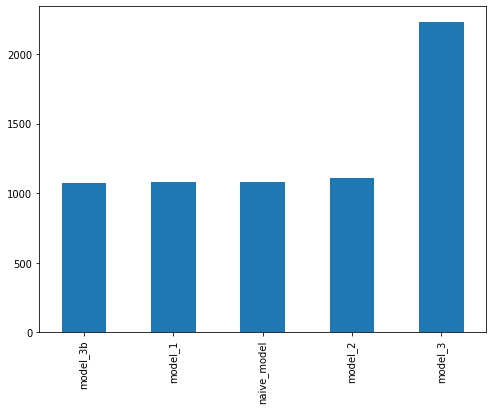

In [156]:
results_dense.MAE.plot(kind='bar', figsize=(8, 6));

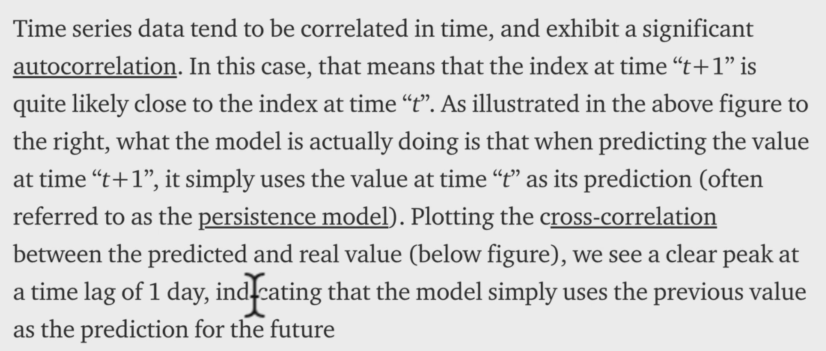

## Model 4: Conv1D Model

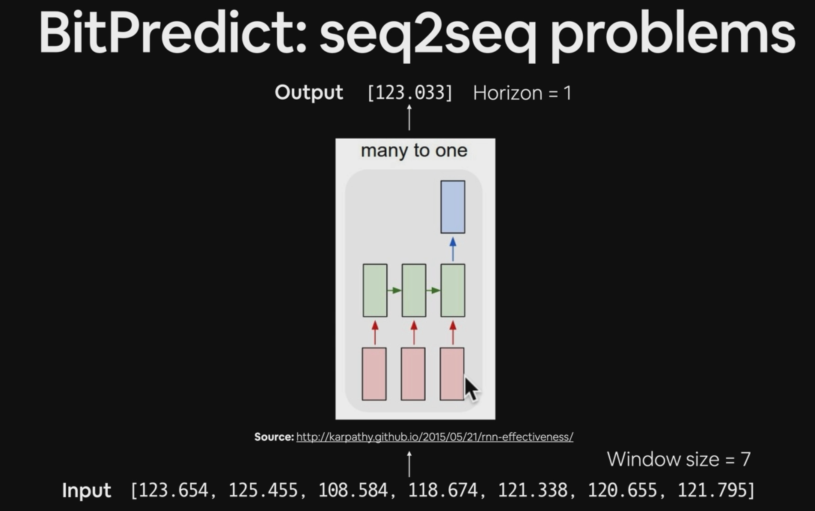

In [157]:
# Create windowed data
# Window=3, Horizon=1

full_windows_31, full_labels_31 = make_windows(np.array(btc_price),
                                               window_size=3,
                                               horizon=1)
train_windows_31, test_windows_31, train_labels_31, test_labels_31 = make_train_test_split(full_windows_31, full_labels_31)

In [158]:
train_windows_31[0]

array([324.467934, 328.644408, 337.921358])

In [159]:
train_windows_31[0].shape

(3,)

In [160]:
train_labels_31[0]

array([348.99286])

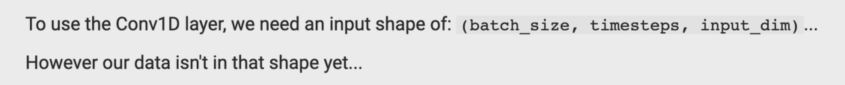

In [161]:
# Reshape train and test windows to follow the time series format
train_windows_31_expanded = np.expand_dims(train_windows_31, axis=-1)
test_windows_31_expanded = np.expand_dims(test_windows_31, axis=-1)

In [162]:
train_windows_31_expanded[0]

array([[324.467934],
       [328.644408],
       [337.921358]])

In [163]:
train_windows_31_expanded[0].shape

(3, 1)

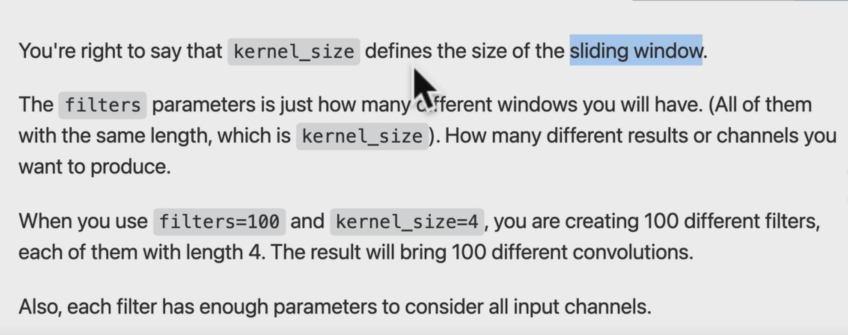

In [164]:
# Create inputs
inputs = layers.Input(shape=(3, 1))

# Create Conv1D layer
x = layers.Conv1D(128, 3, padding='same', activation='relu')(inputs)
x = layers.GlobalMaxPool1D()(x)
x = layers.Dense(1)(x)

model_4 = tf.keras.Model(inputs, x)

In [165]:
model_4.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 3, 1)]            0         
                                                                 
 conv1d (Conv1D)             (None, 3, 128)            512       
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense_12 (Dense)            (None, 1)                 129       
                                                                 
Total params: 641
Trainable params: 641
Non-trainable params: 0
_________________________________________________________________


In [166]:
# Compile the model
model_4.compile(optimizer=Adam(),
                loss='mae')

In [135]:
# Fit the model
hist_4 = model_4.fit(train_windows_31_expanded, train_labels_31,
                     epochs=100,
                     validation_data=(test_windows_31_expanded, test_labels_31),
                     callbacks=make_checkpoint('model_4'))

Epoch 1/100
65/65 [==============================] - ETA: 0s - loss: 679.8546
Epoch 00001: val_loss improved from inf to 1383.63660, saving model to BTC_Model\model_4
INFO:tensorflow:Assets written to: BTC_Model\model_4\assets
65/65 [==============================] - 7s 20ms/step - loss: 679.8546 - val_loss: 1383.6366
Epoch 2/100
55/65 [========================>.....] - ETA: 0s - loss: 165.8415
Epoch 00002: val_loss improved from 1383.63660 to 1368.86792, saving model to BTC_Model\model_4
INFO:tensorflow:Assets written to: BTC_Model\model_4\assets
65/65 [==============================] - 1s 15ms/step - loss: 167.3994 - val_loss: 1368.8679
Epoch 3/100
64/65 [============================>.] - ETA: 0s - loss: 178.2811
Epoch 00003: val_loss improved from 1368.86792 to 1352.09070, saving model to BTC_Model\model_4
INFO:tensorflow:Assets written to: BTC_Model\model_4\assets
65/65 [==============================] - 1s 14ms/step - loss: 177.7760 - val_loss: 1352.0907
Epoch 4/100
57/65 [=======

In [167]:
model_4 = load_model('BTC_Model/model_4/')
model_4.evaluate(test_windows_31_expanded, test_labels_31)

17/17 [==============================] - 3s 4ms/step - loss: 1069.6477


1069.647705078125

In [168]:
model_4_pred = model_4.predict(test_windows_31_expanded)
model_4_results = evaluate_preds(test_labels_31, model_4_pred)
model_4_results

{'MAE': 1069.6477,
 'MSE': 2593301.8,
 'RMSE': 1610.3732,
 'MAPE': 2.78791,
 'MASE': 0.99177676}

In [169]:
naive_results, model_3b_results

({'MAE': 1080.4816,
  'MSE': 2616088.8,
  'RMSE': 1617.4327,
  'MAPE': 2.8337994,
  'MASE': 0.99809825},
 {'MAE': 1072.5979,
  'MSE': 2602797.5,
  'RMSE': 1613.3187,
  'MAPE': 2.7951777,
  'MASE': 0.9945122})

## Model 5: LSTM

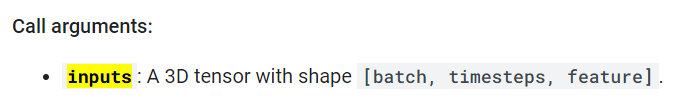

In [170]:
# Create inputs
inputs = layers.Input(shape=(3, 1))

# Create LSTM layer
x = layers.LSTM(128, return_sequences=True, activation='relu')(inputs) # stack lstm
x = layers.LSTM(128, activation='relu')(x)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dense(1)(x)

model_5 = tf.keras.Model(inputs, x)

In [135]:
model_5.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 3, 1)]            0         
                                                                 
 lstm (LSTM)                 (None, 3, 128)            66560     
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dense_9 (Dense)             (None, 32)                4128      
                                                                 
 dense_10 (Dense)            (None, 1)                 33        
                                                                 
Total params: 202,305
Trainable params: 202,305
Non-trainable params: 0
_________________________________________________________________


In [141]:
# Compile the model
model_5.compile(optimizer=Adam(),
                loss='mae')

# Fit the model
hist_5 = model_5.fit(train_windows_31_expanded, train_labels_31,
                     epochs=100,
                     validation_data=(test_windows_31_expanded, test_labels_31),
                     callbacks=make_checkpoint('model_5'))

Epoch 1/100
65/65 [==============================] - ETA: 0s - loss: 1437.1716
Epoch 00001: val_loss improved from inf to 1752.73608, saving model to BTC_Model\model_5
INFO:tensorflow:Assets written to: BTC_Model\model_5\assets


65/65 [==============================] - 7s 69ms/step - loss: 1437.1716 - val_loss: 1752.7361
Epoch 2/100
64/65 [============================>.] - ETA: 0s - loss: 205.7463
Epoch 00002: val_loss improved from 1752.73608 to 1600.04724, saving model to BTC_Model\model_5
INFO:tensorflow:Assets written to: BTC_Model\model_5\assets


INFO:tensorflow:Assets written to: BTC_Model\model_5\assets


65/65 [==============================] - 4s 59ms/step - loss: 205.3531 - val_loss: 1600.0472
Epoch 3/100
63/65 [============================>.] - ETA: 0s - loss: 209.6565
Epoch 00003: val_loss did not improve from 1600.04724
65/65 [==============================] - 1s 21ms/step - loss: 211.0147 - val_loss: 1783.8170
Epoch 4/100
65/65 [==============================] - ETA: 0s - loss: 200.6327
Epoch 00004: val_loss did not improve from 1600.04724
65/65 [==============================] - 1s 21ms/step - loss: 200.6327 - val_loss: 1904.5646
Epoch 5/100
65/65 [==============================] - ETA: 0s - loss: 205.9930
Epoch 00005: val_loss improved from 1600.04724 to 1585.79504, saving model to BTC_Model\model_5
INFO:tensorflow:Assets written to: BTC_Model\model_5\assets


INFO:tensorflow:Assets written to: BTC_Model\model_5\assets


65/65 [==============================] - 4s 63ms/step - loss: 205.9930 - val_loss: 1585.7950
Epoch 6/100
63/65 [============================>.] - ETA: 0s - loss: 211.7919
Epoch 00006: val_loss did not improve from 1585.79504
65/65 [==============================] - 1s 21ms/step - loss: 210.3997 - val_loss: 1630.4216
Epoch 7/100
63/65 [============================>.] - ETA: 0s - loss: 202.5699
Epoch 00007: val_loss did not improve from 1585.79504
65/65 [==============================] - 1s 21ms/step - loss: 200.7215 - val_loss: 1590.0636
Epoch 8/100
64/65 [============================>.] - ETA: 0s - loss: 199.3744
Epoch 00008: val_loss did not improve from 1585.79504
65/65 [==============================] - 1s 22ms/step - loss: 198.6418 - val_loss: 1661.7773
Epoch 9/100
64/65 [============================>.] - ETA: 0s - loss: 203.7892
Epoch 00009: val_loss improved from 1585.79504 to 1536.87817, saving model to BTC_Model\model_5
INFO:tensorflow:Assets written to: BTC_Model\model_5\asset

INFO:tensorflow:Assets written to: BTC_Model\model_5\assets


65/65 [==============================] - 4s 60ms/step - loss: 204.7733 - val_loss: 1536.8782
Epoch 10/100
65/65 [==============================] - ETA: 0s - loss: 194.1983
Epoch 00010: val_loss did not improve from 1536.87817
65/65 [==============================] - 1s 22ms/step - loss: 194.1983 - val_loss: 1879.1431
Epoch 11/100
64/65 [============================>.] - ETA: 0s - loss: 202.5979
Epoch 00011: val_loss did not improve from 1536.87817
65/65 [==============================] - 1s 20ms/step - loss: 204.7299 - val_loss: 1628.5186
Epoch 12/100
65/65 [==============================] - ETA: 0s - loss: 197.6917
Epoch 00012: val_loss did not improve from 1536.87817
65/65 [==============================] - 1s 20ms/step - loss: 197.6917 - val_loss: 1671.9680
Epoch 13/100
63/65 [============================>.] - ETA: 0s - loss: 215.9832
Epoch 00013: val_loss did not improve from 1536.87817
65/65 [==============================] - 2s 24ms/step - loss: 216.7221 - val_loss: 1640.2772
Epo

INFO:tensorflow:Assets written to: BTC_Model\model_5\assets


65/65 [==============================] - 5s 72ms/step - loss: 188.5670 - val_loss: 1498.1945
Epoch 15/100
62/65 [===========================>..] - ETA: 0s - loss: 183.0633
Epoch 00015: val_loss did not improve from 1498.19446
65/65 [==============================] - 1s 21ms/step - loss: 186.7819 - val_loss: 1499.0909
Epoch 16/100
65/65 [==============================] - ETA: 0s - loss: 213.0023
Epoch 00016: val_loss did not improve from 1498.19446
65/65 [==============================] - 1s 22ms/step - loss: 213.0023 - val_loss: 1562.4351
Epoch 17/100
63/65 [============================>.] - ETA: 0s - loss: 182.6276
Epoch 00017: val_loss improved from 1498.19446 to 1448.73108, saving model to BTC_Model\model_5
INFO:tensorflow:Assets written to: BTC_Model\model_5\assets


INFO:tensorflow:Assets written to: BTC_Model\model_5\assets


65/65 [==============================] - 5s 80ms/step - loss: 182.1272 - val_loss: 1448.7311
Epoch 18/100
64/65 [============================>.] - ETA: 0s - loss: 186.4693
Epoch 00018: val_loss did not improve from 1448.73108
65/65 [==============================] - 1s 21ms/step - loss: 187.3666 - val_loss: 1449.9264
Epoch 19/100
65/65 [==============================] - ETA: 0s - loss: 178.0877
Epoch 00019: val_loss improved from 1448.73108 to 1440.79895, saving model to BTC_Model\model_5
INFO:tensorflow:Assets written to: BTC_Model\model_5\assets


INFO:tensorflow:Assets written to: BTC_Model\model_5\assets


65/65 [==============================] - 4s 62ms/step - loss: 178.0877 - val_loss: 1440.7990
Epoch 20/100
64/65 [============================>.] - ETA: 0s - loss: 180.3214
Epoch 00020: val_loss did not improve from 1440.79895
65/65 [==============================] - 1s 19ms/step - loss: 179.6110 - val_loss: 1445.4692
Epoch 21/100
65/65 [==============================] - ETA: 0s - loss: 176.8895
Epoch 00021: val_loss improved from 1440.79895 to 1414.55188, saving model to BTC_Model\model_5
INFO:tensorflow:Assets written to: BTC_Model\model_5\assets


INFO:tensorflow:Assets written to: BTC_Model\model_5\assets


65/65 [==============================] - 4s 61ms/step - loss: 176.8895 - val_loss: 1414.5519
Epoch 22/100
65/65 [==============================] - ETA: 0s - loss: 174.2858
Epoch 00022: val_loss did not improve from 1414.55188
65/65 [==============================] - 1s 20ms/step - loss: 174.2858 - val_loss: 1469.2930
Epoch 23/100
64/65 [============================>.] - ETA: 0s - loss: 192.6557
Epoch 00023: val_loss improved from 1414.55188 to 1345.75757, saving model to BTC_Model\model_5
INFO:tensorflow:Assets written to: BTC_Model\model_5\assets


INFO:tensorflow:Assets written to: BTC_Model\model_5\assets


65/65 [==============================] - 4s 55ms/step - loss: 193.2642 - val_loss: 1345.7576
Epoch 24/100
65/65 [==============================] - ETA: 0s - loss: 175.6464
Epoch 00024: val_loss improved from 1345.75757 to 1331.31958, saving model to BTC_Model\model_5
INFO:tensorflow:Assets written to: BTC_Model\model_5\assets


INFO:tensorflow:Assets written to: BTC_Model\model_5\assets


65/65 [==============================] - 4s 63ms/step - loss: 175.6464 - val_loss: 1331.3196
Epoch 25/100
64/65 [============================>.] - ETA: 0s - loss: 173.0265
Epoch 00025: val_loss improved from 1331.31958 to 1330.80847, saving model to BTC_Model\model_5
INFO:tensorflow:Assets written to: BTC_Model\model_5\assets


INFO:tensorflow:Assets written to: BTC_Model\model_5\assets


65/65 [==============================] - 4s 58ms/step - loss: 172.2088 - val_loss: 1330.8085
Epoch 26/100
63/65 [============================>.] - ETA: 0s - loss: 164.6945
Epoch 00026: val_loss improved from 1330.80847 to 1275.89160, saving model to BTC_Model\model_5
INFO:tensorflow:Assets written to: BTC_Model\model_5\assets


INFO:tensorflow:Assets written to: BTC_Model\model_5\assets


65/65 [==============================] - 4s 59ms/step - loss: 164.7104 - val_loss: 1275.8916
Epoch 27/100
62/65 [===========================>..] - ETA: 0s - loss: 160.1705
Epoch 00027: val_loss improved from 1275.89160 to 1242.08252, saving model to BTC_Model\model_5
INFO:tensorflow:Assets written to: BTC_Model\model_5\assets


INFO:tensorflow:Assets written to: BTC_Model\model_5\assets


65/65 [==============================] - 4s 61ms/step - loss: 161.3127 - val_loss: 1242.0825
Epoch 28/100
64/65 [============================>.] - ETA: 0s - loss: 159.0819
Epoch 00028: val_loss improved from 1242.08252 to 1222.37598, saving model to BTC_Model\model_5
INFO:tensorflow:Assets written to: BTC_Model\model_5\assets


INFO:tensorflow:Assets written to: BTC_Model\model_5\assets


65/65 [==============================] - 4s 58ms/step - loss: 158.0907 - val_loss: 1222.3760
Epoch 29/100
65/65 [==============================] - ETA: 0s - loss: 159.5730
Epoch 00029: val_loss did not improve from 1222.37598
65/65 [==============================] - 1s 21ms/step - loss: 159.5730 - val_loss: 1227.6854
Epoch 30/100
65/65 [==============================] - ETA: 0s - loss: 159.2288
Epoch 00030: val_loss did not improve from 1222.37598
65/65 [==============================] - 1s 22ms/step - loss: 159.2288 - val_loss: 1245.7817
Epoch 31/100
65/65 [==============================] - ETA: 0s - loss: 148.2124
Epoch 00031: val_loss did not improve from 1222.37598
65/65 [==============================] - 1s 19ms/step - loss: 148.2124 - val_loss: 1375.5946
Epoch 32/100
64/65 [============================>.] - ETA: 0s - loss: 159.2705
Epoch 00032: val_loss improved from 1222.37598 to 1191.74292, saving model to BTC_Model\model_5
INFO:tensorflow:Assets written to: BTC_Model\model_5\a

INFO:tensorflow:Assets written to: BTC_Model\model_5\assets


65/65 [==============================] - 3s 53ms/step - loss: 158.7591 - val_loss: 1191.7429
Epoch 33/100
64/65 [============================>.] - ETA: 0s - loss: 143.5998
Epoch 00033: val_loss did not improve from 1191.74292
65/65 [==============================] - 1s 21ms/step - loss: 144.5782 - val_loss: 1378.0994
Epoch 34/100
62/65 [===========================>..] - ETA: 0s - loss: 159.6124
Epoch 00034: val_loss did not improve from 1191.74292
65/65 [==============================] - 1s 20ms/step - loss: 157.5831 - val_loss: 1649.6240
Epoch 35/100
64/65 [============================>.] - ETA: 0s - loss: 162.5241
Epoch 00035: val_loss did not improve from 1191.74292
65/65 [==============================] - 1s 20ms/step - loss: 162.5511 - val_loss: 1727.4025
Epoch 36/100
64/65 [============================>.] - ETA: 0s - loss: 166.3736
Epoch 00036: val_loss did not improve from 1191.74292
65/65 [==============================] - 1s 20ms/step - loss: 166.4834 - val_loss: 1295.4174
Epo

INFO:tensorflow:Assets written to: BTC_Model\model_5\assets


65/65 [==============================] - 4s 59ms/step - loss: 164.3288 - val_loss: 1112.5582
Epoch 39/100
65/65 [==============================] - ETA: 0s - loss: 141.4146
Epoch 00039: val_loss did not improve from 1112.55823
65/65 [==============================] - 1s 21ms/step - loss: 141.4146 - val_loss: 1152.2078
Epoch 40/100
65/65 [==============================] - ETA: 0s - loss: 144.5139
Epoch 00040: val_loss did not improve from 1112.55823
65/65 [==============================] - 1s 20ms/step - loss: 144.5139 - val_loss: 1200.5377
Epoch 41/100
64/65 [============================>.] - ETA: 0s - loss: 161.1440
Epoch 00041: val_loss improved from 1112.55823 to 1082.57190, saving model to BTC_Model\model_5
INFO:tensorflow:Assets written to: BTC_Model\model_5\assets


INFO:tensorflow:Assets written to: BTC_Model\model_5\assets


65/65 [==============================] - 4s 58ms/step - loss: 161.0191 - val_loss: 1082.5719
Epoch 42/100
64/65 [============================>.] - ETA: 0s - loss: 150.5615
Epoch 00042: val_loss did not improve from 1082.57190
65/65 [==============================] - 1s 20ms/step - loss: 150.2570 - val_loss: 1709.6151
Epoch 43/100
64/65 [============================>.] - ETA: 0s - loss: 152.7373
Epoch 00043: val_loss did not improve from 1082.57190
65/65 [==============================] - 2s 24ms/step - loss: 152.1727 - val_loss: 1091.4749
Epoch 44/100
63/65 [============================>.] - ETA: 0s - loss: 137.7288
Epoch 00044: val_loss did not improve from 1082.57190
65/65 [==============================] - 1s 22ms/step - loss: 138.1624 - val_loss: 1156.9814
Epoch 45/100
64/65 [============================>.] - ETA: 0s - loss: 148.0421
Epoch 00045: val_loss did not improve from 1082.57190
65/65 [==============================] - 1s 23ms/step - loss: 147.7121 - val_loss: 1143.4258
Epo

INFO:tensorflow:Assets written to: BTC_Model\model_5\assets


65/65 [==============================] - 4s 69ms/step - loss: 137.8601 - val_loss: 1073.5597
Epoch 52/100
62/65 [===========================>..] - ETA: 0s - loss: 136.4274
Epoch 00052: val_loss did not improve from 1073.55969
65/65 [==============================] - 1s 23ms/step - loss: 136.2544 - val_loss: 1240.6937
Epoch 53/100
65/65 [==============================] - ETA: 0s - loss: 141.1810
Epoch 00053: val_loss did not improve from 1073.55969
65/65 [==============================] - 2s 24ms/step - loss: 141.1810 - val_loss: 1436.8857
Epoch 54/100
65/65 [==============================] - ETA: 0s - loss: 149.6059
Epoch 00054: val_loss did not improve from 1073.55969
65/65 [==============================] - 1s 23ms/step - loss: 149.6059 - val_loss: 1187.2719
Epoch 55/100
65/65 [==============================] - ETA: 0s - loss: 135.8398
Epoch 00055: val_loss did not improve from 1073.55969
65/65 [==============================] - 1s 21ms/step - loss: 135.8398 - val_loss: 1109.3754
Epo

INFO:tensorflow:Assets written to: BTC_Model\model_5\assets


65/65 [==============================] - 5s 70ms/step - loss: 133.9388 - val_loss: 1070.4160
Epoch 72/100
64/65 [============================>.] - ETA: 0s - loss: 136.0054
Epoch 00072: val_loss did not improve from 1070.41602
65/65 [==============================] - 2s 24ms/step - loss: 135.1569 - val_loss: 1092.5812
Epoch 73/100
65/65 [==============================] - ETA: 0s - loss: 134.5805
Epoch 00073: val_loss did not improve from 1070.41602
65/65 [==============================] - 1s 23ms/step - loss: 134.5805 - val_loss: 1185.5356
Epoch 74/100
64/65 [============================>.] - ETA: 0s - loss: 138.9800
Epoch 00074: val_loss did not improve from 1070.41602
65/65 [==============================] - 1s 22ms/step - loss: 139.1492 - val_loss: 1156.9128
Epoch 75/100
63/65 [============================>.] - ETA: 0s - loss: 137.8888
Epoch 00075: val_loss did not improve from 1070.41602
65/65 [==============================] - 1s 23ms/step - loss: 138.0139 - val_loss: 1075.0388
Epo

In [591]:
model_5 = load_model('BTC_Model/model_5/')
model_5.evaluate(test_windows_31_expanded, test_labels_31)

17/17 [==============================] - 0s 4ms/step - loss: 1070.4160


1070.416015625

In [592]:
model_5_pred = model_5.predict(test_windows_31_expanded)
model_5_results = evaluate_preds(test_labels_31_pd, model_5_pred)
model_5_results

{'MAE': 1070.4161,
 'MSE': 2600308.8,
 'RMSE': 1612.5472,
 'MAPE': 2.8050356,
 'MASE': 0.9924893}

In [172]:
naive_results, model_3b_results, model_4_results

({'MAE': 1080.4816,
  'MSE': 2616088.8,
  'RMSE': 1617.4327,
  'MAPE': 2.8337994,
  'MASE': 0.99809825},
 {'MAE': 1072.5979,
  'MSE': 2602797.5,
  'RMSE': 1613.3187,
  'MAPE': 2.7951777,
  'MASE': 0.9945122},
 {'MAE': 1069.6477,
  'MSE': 2593301.8,
  'RMSE': 1610.3732,
  'MAPE': 2.78791,
  'MASE': 0.99177676})

## Multivariate Model

One feature we could add is whether Elon Musk tweeted on that day..

* day 1 - 0
* day 2 - 1
* day 3 - 0

How about bitcoin halving events?

In [173]:
df2.head()

Price
Date                  
2014-11-04  324.467934
2014-11-05  328.644408
2014-11-06  337.921358
2014-11-07  348.992860
2014-11-08  341.459753

In [174]:
df2_new = df2.copy()

In [175]:
len(df2_new)

2597

In [176]:
block_reward_1 = 50 # 3 January 2009
block_reward_2 = 25 # 8 November 2012
block_reward_3 = 12.5 # 9 July 2016
block_reward_4 = 6.25 # 18 May 2020

# Block reward datetimes
block_reward_2_datetime = np.datetime64('2012-11-08')
block_reward_3_datetime = np.datetime64('2016-07-09')
block_reward_4_datetime = np.datetime64('2020-05-18')

In [177]:
block_reward = []
for i in df2_new.index:
    if block_reward_2_datetime <= i < block_reward_3_datetime:
        block_reward.append(block_reward_2)
    elif block_reward_3_datetime <= i < block_reward_4_datetime:
        block_reward.append(block_reward_3)
    else:
        block_reward.append(block_reward_4)

In [178]:
block_reward[:10], block_reward[-10:]

([25, 25, 25, 25, 25, 25, 25, 25, 25, 25],
 [6.25, 6.25, 6.25, 6.25, 6.25, 6.25, 6.25, 6.25, 6.25, 6.25])

In [179]:
df2_new['Block_Reward'] = block_reward

In [180]:
df2_new

Price  Block_Reward
Date                                  
2014-11-04    324.467934         25.00
2014-11-05    328.644408         25.00
2014-11-06    337.921358         25.00
2014-11-07    348.992860         25.00
2014-11-08    341.459753         25.00
...                  ...           ...
2021-12-09  50512.038512          6.25
2021-12-10  47594.381934          6.25
2021-12-11  47162.324050          6.25
2021-12-12  49353.419314          6.25
2021-12-13  50103.541821          6.25

[2597 rows x 2 columns]

In [181]:
np.datetime64('2021-11-11') > np.datetime64('2020-11-11')

True

In [182]:
time_steps[:5]

[datetime.datetime(2014, 11, 4, 0, 0),
 datetime.datetime(2014, 11, 5, 0, 0),
 datetime.datetime(2014, 11, 6, 0, 0),
 datetime.datetime(2014, 11, 7, 0, 0),
 datetime.datetime(2014, 11, 8, 0, 0)]

In [183]:
len(train_labels_31)

2075

In [184]:
train_block_reward = block_reward[:2075]
test_block_reward = block_reward[2075:]

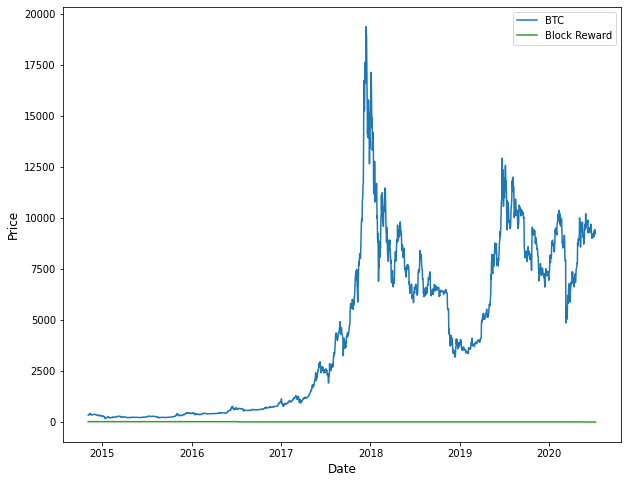

In [185]:
plt.figure(figsize=(10, 8))
plot_graph_zoomed(time_steps[:2075], train_labels_31, label='BTC', train_size=1)
plot_graph_zoomed(time_steps[:2075], train_block_reward, label='Block Reward', train_size=1)

In [186]:
# Plot block reward vs price over time
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_labels_31_scaled = scaler.fit_transform(train_labels_31)
train_block_reward_scaled = scaler.fit_transform(np.expand_dims(train_block_reward, axis=-1))

In [187]:
train_block_reward[:10]

[25, 25, 25, 25, 25, 25, 25, 25, 25, 25]

In [188]:
np.expand_dims(train_block_reward, axis=-1)

array([[25.  ],
       [25.  ],
       [25.  ],
       ...,
       [ 6.25],
       [ 6.25],
       [ 6.25]])

In [189]:
train_labels_31

array([[ 348.99286 ],
       [ 341.459753],
       [ 344.745289],
       ...,
       [9237.455308],
       [9286.942248],
       [9235.143666]])

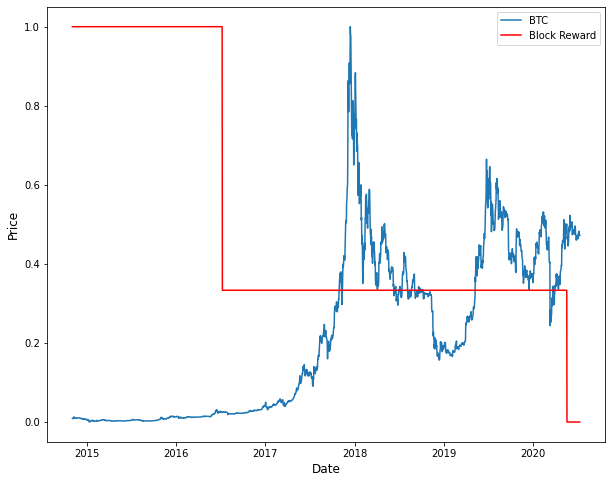

In [190]:
plt.figure(figsize=(10, 8))
plot_graph_zoomed(time_steps[:2075], train_labels_31_scaled, label='BTC', train_size=1)
plot_graph_zoomed(time_steps[:2075], train_block_reward_scaled, label='Block Reward', train_size=1, color='red')

## Making windowed dataset using df.shift()

In [191]:
df2_new.head()

Price  Block_Reward
Date                                
2014-11-04  324.467934          25.0
2014-11-05  328.644408          25.0
2014-11-06  337.921358          25.0
2014-11-07  348.992860          25.0
2014-11-08  341.459753          25.0

In [192]:
for i in range(3):
    df2_new[f'Price+{i+1}'] = df2_new.Price.shift(periods=i+1)

In [193]:
df2_new[:10]

Price  Block_Reward     Price+1     Price+2     Price+3
Date                                                                    
2014-11-04  324.467934          25.0         NaN         NaN         NaN
2014-11-05  328.644408          25.0  324.467934         NaN         NaN
2014-11-06  337.921358          25.0  328.644408  324.467934         NaN
2014-11-07  348.992860          25.0  337.921358  328.644408  324.467934
2014-11-08  341.459753          25.0  348.992860  337.921358  328.644408
2014-11-09  344.745289          25.0  341.459753  348.992860  337.921358
2014-11-10  357.239982          25.0  344.745289  341.459753  348.992860
2014-11-11  371.116917          25.0  357.239982  344.745289  341.459753
2014-11-12  366.664633          25.0  371.116917  357.239982  344.745289
2014-11-13  428.882925          25.0  366.664633  371.116917  357.239982

In [194]:
train_windows_31[0], train_labels_31[0]

(array([324.467934, 328.644408, 337.921358]), array([348.99286]))

In [195]:
full_windows_31_pd = df2_new[['Price+3', 'Price+2', 'Price+1']].to_numpy()[3:]

In [196]:
full_windows_31_pd = full_windows_31_pd.astype(np.float32)
full_windows_31_pd

array([[  324.46793,   328.6444 ,   337.92136],
       [  328.6444 ,   337.92136,   348.99286],
       [  337.92136,   348.99286,   341.45975],
       ...,
       [50638.164  , 50512.04   , 47594.383  ],
       [50512.04   , 47594.383  , 47162.324  ],
       [47594.383  , 47162.324  , 49353.418  ]], dtype=float32)

In [197]:
full_labels_31_pd = df2_new['Price'][3:].to_numpy()
full_labels_31_pd = np.expand_dims(full_labels_31_pd, axis=-1)
full_labels_31_pd = full_labels_31_pd.astype(np.float32)
full_labels_31_pd

array([[  348.99286],
       [  341.45975],
       [  344.7453 ],
       ...,
       [47162.324  ],
       [49353.418  ],
       [50103.543  ]], dtype=float32)

In [198]:
split_size = int(0.8 * len(full_windows_31_pd))

train_windows_31_pd = full_windows_31_pd[:split_size]
test_windows_31_pd = full_windows_31_pd[split_size:]

train_labels_31_pd = full_labels_31_pd[:split_size]
test_labels_31_pd = full_labels_31_pd[split_size:]

In [199]:
full_block_reward = df2_new.Block_Reward[3:].to_numpy()

train_block_reward = full_block_reward[:split_size]
test_block_reward = full_block_reward[split_size:]

In [200]:
train_block_reward = np.expand_dims(train_block_reward, axis=-1)
test_block_reward = np.expand_dims(test_block_reward, axis=-1)

In [201]:
train_block_reward = train_block_reward.astype(np.float32)
test_block_reward = test_block_reward.astype(np.float32)

In [202]:
train_windows_31_pd, train_block_reward[:10]

(array([[ 324.46793,  328.6444 ,  337.92136],
        [ 328.6444 ,  337.92136,  348.99286],
        [ 337.92136,  348.99286,  341.45975],
        ...,
        [9346.448  , 9253.988  , 9437.699  ],
        [9253.988  , 9437.699  , 9237.455  ],
        [9437.699  , 9237.455  , 9286.942  ]], dtype=float32),
 array([[25.],
        [25.],
        [25.],
        [25.],
        [25.],
        [25.],
        [25.],
        [25.],
        [25.],
        [25.]], dtype=float32))

In [203]:
train_windows_31_pd = np.expand_dims(train_windows_31_pd, axis=-1)
test_windows_31_pd = np.expand_dims(test_windows_31_pd, axis=-1)

In [204]:
train_windows_31_pd

array([[[ 324.46793],
        [ 328.6444 ],
        [ 337.92136]],

       [[ 328.6444 ],
        [ 337.92136],
        [ 348.99286]],

       [[ 337.92136],
        [ 348.99286],
        [ 341.45975]],

       ...,

       [[9346.448  ],
        [9253.988  ],
        [9437.699  ]],

       [[9253.988  ],
        [9437.699  ],
        [9237.455  ]],

       [[9437.699  ],
        [9237.455  ],
        [9286.942  ]]], dtype=float32)

In [205]:
train_windows_31_pd[0].shape, train_block_reward[0].shape

((3, 1), (1,))

In [206]:
# Create inputs
price_input = layers.Input(shape=(3, 1))
block_reward_input = layers.Input(shape=(1))

# Create Conv1D layer for price and Dense layer for block reward
x = layers.Conv1D(filters=128, kernel_size=3, padding='same', activation='relu')(price_input)
x = layers.GlobalMaxPool1D()(x)
x = layers.Dense(128, activation='relu')(x)
price_model = tf.keras.Model(price_input, x)

y = layers.Dense(128, activation='relu')(block_reward_input)
block_reward_model = tf.keras.Model(block_reward_input, y)

# Concatenate model
z = layers.Concatenate()([price_model.output, block_reward_model.output])
z = layers.Dense(128, activation='relu')(z)
z = layers.Dense(1, activation='linear')(z)

# Build a model
model_6 = tf.keras.Model(inputs=[price_model.input, block_reward_model.input],
                         outputs=z)

In [207]:
model_6.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 3, 1)]       0           []                               
                                                                                                  
 conv1d_1 (Conv1D)              (None, 3, 128)       512         ['input_9[0][0]']                
                                                                                                  
 global_max_pooling1d_1 (Global  (None, 128)         0           ['conv1d_1[0][0]']               
 MaxPooling1D)                                                                                    
                                                                                                  
 input_10 (InputLayer)          [(None, 1)]          0           []                         

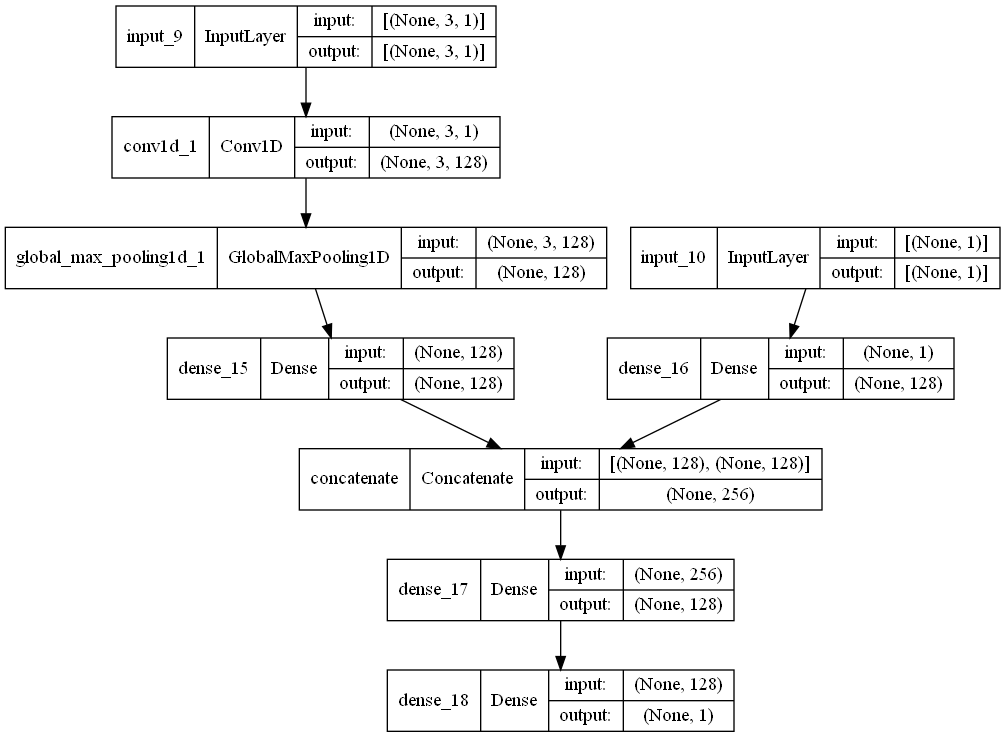

In [208]:
tf.keras.utils.plot_model(model_6, show_shapes=True)

In [209]:
TRAIN_DATA = tf.data.Dataset.from_tensor_slices((train_windows_31_pd, train_block_reward))
TEST_DATA = tf.data.Dataset.from_tensor_slices((test_windows_31_pd, test_block_reward))
train_labels_31_pd = tf.data.Dataset.from_tensor_slices(train_labels_31_pd)
test_labels_31_pd = tf.data.Dataset.from_tensor_slices(test_labels_31_pd)

In [210]:
TRAIN_DATA = tf.data.Dataset.zip((TRAIN_DATA, train_labels_31_pd)).batch(128)
TEST_DATA = tf.data.Dataset.zip((TEST_DATA, test_labels_31_pd)).batch(128)

In [211]:
TRAIN_DATA

<BatchDataset shapes: (((None, 3, 1), (None, 1)), (None, 1)), types: ((tf.float32, tf.float32), tf.float32)>

In [184]:
# Compile the model
model_6.compile(optimizer=Adam(),
                loss='mae')

# Fit the model
hist_6 = model_6.fit(TRAIN_DATA,
                     epochs=100,
                     validation_data=TEST_DATA,
                     callbacks=make_checkpoint('model_6'))

Epoch 1/100
13/17 [=====================>........] - ETA: 0s - loss: 1726.3984
Epoch 00001: val_loss improved from inf to 3963.46436, saving model to BTC_Model\model_6
INFO:tensorflow:Assets written to: BTC_Model\model_6\assets


INFO:tensorflow:Assets written to: BTC_Model\model_6\assets


17/17 [==============================] - 2s 77ms/step - loss: 1694.5605 - val_loss: 3963.4644
Epoch 2/100
 9/17 [==============>...............] - ETA: 0s - loss: 567.9578
Epoch 00002: val_loss did not improve from 3963.46436
17/17 [==============================] - 0s 8ms/step - loss: 925.0657 - val_loss: 5204.6270
Epoch 3/100
13/17 [=====================>........] - ETA: 0s - loss: 461.0059
Epoch 00003: val_loss improved from 3963.46436 to 2376.38965, saving model to BTC_Model\model_6
INFO:tensorflow:Assets written to: BTC_Model\model_6\assets


INFO:tensorflow:Assets written to: BTC_Model\model_6\assets


17/17 [==============================] - 1s 55ms/step - loss: 478.7311 - val_loss: 2376.3896
Epoch 4/100
11/17 [==================>...........] - ETA: 0s - loss: 158.4286
Epoch 00004: val_loss improved from 2376.38965 to 1468.56909, saving model to BTC_Model\model_6
INFO:tensorflow:Assets written to: BTC_Model\model_6\assets


INFO:tensorflow:Assets written to: BTC_Model\model_6\assets


17/17 [==============================] - 1s 87ms/step - loss: 192.5947 - val_loss: 1468.5691
Epoch 5/100
12/17 [====================>.........] - ETA: 0s - loss: 178.1063
Epoch 00005: val_loss did not improve from 1468.56909
17/17 [==============================] - 0s 12ms/step - loss: 220.5600 - val_loss: 1544.8596
Epoch 6/100
11/17 [==================>...........] - ETA: 0s - loss: 168.8025
Epoch 00006: val_loss did not improve from 1468.56909
17/17 [==============================] - 0s 7ms/step - loss: 209.7867 - val_loss: 1553.2323
Epoch 7/100
12/17 [====================>.........] - ETA: 0s - loss: 145.9522
Epoch 00007: val_loss improved from 1468.56909 to 1386.27100, saving model to BTC_Model\model_6
INFO:tensorflow:Assets written to: BTC_Model\model_6\assets


INFO:tensorflow:Assets written to: BTC_Model\model_6\assets


17/17 [==============================] - 1s 65ms/step - loss: 178.8219 - val_loss: 1386.2710
Epoch 8/100
15/17 [=========================>....] - ETA: 0s - loss: 151.6099
Epoch 00008: val_loss improved from 1386.27100 to 1352.90076, saving model to BTC_Model\model_6
INFO:tensorflow:Assets written to: BTC_Model\model_6\assets


INFO:tensorflow:Assets written to: BTC_Model\model_6\assets


17/17 [==============================] - 1s 68ms/step - loss: 160.5634 - val_loss: 1352.9008
Epoch 9/100
11/17 [==================>...........] - ETA: 0s - loss: 151.1380
Epoch 00009: val_loss did not improve from 1352.90076
17/17 [==============================] - 0s 7ms/step - loss: 190.2780 - val_loss: 1406.1456
Epoch 10/100
13/17 [=====================>........] - ETA: 0s - loss: 140.7285
Epoch 00010: val_loss improved from 1352.90076 to 1288.61450, saving model to BTC_Model\model_6
INFO:tensorflow:Assets written to: BTC_Model\model_6\assets


INFO:tensorflow:Assets written to: BTC_Model\model_6\assets


17/17 [==============================] - 1s 70ms/step - loss: 174.5565 - val_loss: 1288.6145
Epoch 11/100
12/17 [====================>.........] - ETA: 0s - loss: 150.0768
Epoch 00011: val_loss did not improve from 1288.61450
17/17 [==============================] - 0s 6ms/step - loss: 184.4433 - val_loss: 1350.8624
Epoch 12/100
13/17 [=====================>........] - ETA: 0s - loss: 159.0059
Epoch 00012: val_loss did not improve from 1288.61450
17/17 [==============================] - 0s 7ms/step - loss: 203.9814 - val_loss: 1541.4280
Epoch 13/100
10/17 [================>.............] - ETA: 0s - loss: 117.0288
Epoch 00013: val_loss did not improve from 1288.61450
17/17 [==============================] - 0s 8ms/step - loss: 156.7525 - val_loss: 1318.5223
Epoch 14/100
10/17 [================>.............] - ETA: 0s - loss: 127.7413
Epoch 00014: val_loss improved from 1288.61450 to 1264.22229, saving model to BTC_Model\model_6
INFO:tensorflow:Assets written to: BTC_Model\model_6\asse

INFO:tensorflow:Assets written to: BTC_Model\model_6\assets


17/17 [==============================] - 1s 68ms/step - loss: 164.7776 - val_loss: 1264.2223
Epoch 15/100
10/17 [================>.............] - ETA: 0s - loss: 119.8200
Epoch 00015: val_loss did not improve from 1264.22229
17/17 [==============================] - 0s 7ms/step - loss: 163.9674 - val_loss: 1302.4938
Epoch 16/100
13/17 [=====================>........] - ETA: 0s - loss: 207.7661
Epoch 00016: val_loss did not improve from 1264.22229
17/17 [==============================] - 0s 7ms/step - loss: 258.9511 - val_loss: 1805.4178
Epoch 17/100
11/17 [==================>...........] - ETA: 0s - loss: 141.7861
Epoch 00017: val_loss improved from 1264.22229 to 1252.15991, saving model to BTC_Model\model_6
INFO:tensorflow:Assets written to: BTC_Model\model_6\assets


INFO:tensorflow:Assets written to: BTC_Model\model_6\assets


17/17 [==============================] - 1s 65ms/step - loss: 172.2830 - val_loss: 1252.1599
Epoch 18/100
13/17 [=====================>........] - ETA: 0s - loss: 176.8068
Epoch 00018: val_loss did not improve from 1252.15991
17/17 [==============================] - 0s 7ms/step - loss: 227.9644 - val_loss: 1733.1260
Epoch 19/100
13/17 [=====================>........] - ETA: 0s - loss: 141.6646
Epoch 00019: val_loss improved from 1252.15991 to 1248.79102, saving model to BTC_Model\model_6
INFO:tensorflow:Assets written to: BTC_Model\model_6\assets


INFO:tensorflow:Assets written to: BTC_Model\model_6\assets


17/17 [==============================] - 1s 67ms/step - loss: 172.6893 - val_loss: 1248.7910
Epoch 20/100
13/17 [=====================>........] - ETA: 0s - loss: 169.3386
Epoch 00020: val_loss did not improve from 1248.79102
17/17 [==============================] - 0s 7ms/step - loss: 208.3619 - val_loss: 1576.4221
Epoch 21/100
11/17 [==================>...........] - ETA: 0s - loss: 123.1653
Epoch 00021: val_loss did not improve from 1248.79102
17/17 [==============================] - 0s 7ms/step - loss: 159.0959 - val_loss: 1270.7654
Epoch 22/100
 9/17 [==============>...............] - ETA: 0s - loss: 126.6639
Epoch 00022: val_loss did not improve from 1248.79102
17/17 [==============================] - 0s 9ms/step - loss: 224.8219 - val_loss: 1637.2183
Epoch 23/100
13/17 [=====================>........] - ETA: 0s - loss: 128.9479
Epoch 00023: val_loss improved from 1248.79102 to 1244.45288, saving model to BTC_Model\model_6
INFO:tensorflow:Assets written to: BTC_Model\model_6\asse

INFO:tensorflow:Assets written to: BTC_Model\model_6\assets


17/17 [==============================] - 1s 73ms/step - loss: 159.7421 - val_loss: 1244.4529
Epoch 24/100
10/17 [================>.............] - ETA: 0s - loss: 152.3528
Epoch 00024: val_loss did not improve from 1244.45288
17/17 [==============================] - 0s 8ms/step - loss: 201.4844 - val_loss: 1537.9025
Epoch 25/100
13/17 [=====================>........] - ETA: 0s - loss: 124.1461
Epoch 00025: val_loss did not improve from 1244.45288
17/17 [==============================] - 0s 6ms/step - loss: 154.4590 - val_loss: 1257.0680
Epoch 26/100
14/17 [=======================>......] - ETA: 0s - loss: 199.5404
Epoch 00026: val_loss did not improve from 1244.45288
17/17 [==============================] - 0s 9ms/step - loss: 212.7003 - val_loss: 1571.7882
Epoch 27/100
14/17 [=======================>......] - ETA: 0s - loss: 142.4551
Epoch 00027: val_loss improved from 1244.45288 to 1243.17432, saving model to BTC_Model\model_6
INFO:tensorflow:Assets written to: BTC_Model\model_6\asse

INFO:tensorflow:Assets written to: BTC_Model\model_6\assets


17/17 [==============================] - 1s 92ms/step - loss: 154.9509 - val_loss: 1243.1743
Epoch 28/100
13/17 [=====================>........] - ETA: 0s - loss: 173.0986
Epoch 00028: val_loss did not improve from 1243.17432
17/17 [==============================] - 0s 7ms/step - loss: 215.1678 - val_loss: 1580.9508
Epoch 29/100
11/17 [==================>...........] - ETA: 0s - loss: 121.3986
Epoch 00029: val_loss improved from 1243.17432 to 1223.03149, saving model to BTC_Model\model_6
INFO:tensorflow:Assets written to: BTC_Model\model_6\assets


INFO:tensorflow:Assets written to: BTC_Model\model_6\assets


17/17 [==============================] - 1s 65ms/step - loss: 154.4389 - val_loss: 1223.0315
Epoch 30/100
12/17 [====================>.........] - ETA: 0s - loss: 148.8392
Epoch 00030: val_loss did not improve from 1223.03149
17/17 [==============================] - 0s 7ms/step - loss: 182.9951 - val_loss: 1326.9222
Epoch 31/100
15/17 [=========================>....] - ETA: 0s - loss: 163.2723
Epoch 00031: val_loss did not improve from 1223.03149
17/17 [==============================] - 0s 6ms/step - loss: 173.0485 - val_loss: 1235.1520
Epoch 32/100
12/17 [====================>.........] - ETA: 0s - loss: 145.8068
Epoch 00032: val_loss did not improve from 1223.03149
17/17 [==============================] - 0s 7ms/step - loss: 179.4967 - val_loss: 1268.2642
Epoch 33/100
12/17 [====================>.........] - ETA: 0s - loss: 148.7337
Epoch 00033: val_loss did not improve from 1223.03149
17/17 [==============================] - 0s 6ms/step - loss: 204.8126 - val_loss: 1628.6848
Epoch 3

INFO:tensorflow:Assets written to: BTC_Model\model_6\assets


17/17 [==============================] - 1s 75ms/step - loss: 154.3216 - val_loss: 1193.7134
Epoch 37/100
12/17 [====================>.........] - ETA: 0s - loss: 153.5140
Epoch 00037: val_loss did not improve from 1193.71338
17/17 [==============================] - 0s 7ms/step - loss: 190.7039 - val_loss: 1422.3954
Epoch 38/100
12/17 [====================>.........] - ETA: 0s - loss: 122.7153
Epoch 00038: val_loss did not improve from 1193.71338
17/17 [==============================] - 0s 8ms/step - loss: 158.5513 - val_loss: 1197.4050
Epoch 39/100
12/17 [====================>.........] - ETA: 0s - loss: 170.4662
Epoch 00039: val_loss did not improve from 1193.71338
17/17 [==============================] - 0s 7ms/step - loss: 216.9449 - val_loss: 1572.3163
Epoch 40/100
12/17 [====================>.........] - ETA: 0s - loss: 121.0479
Epoch 00040: val_loss improved from 1193.71338 to 1186.93921, saving model to BTC_Model\model_6
INFO:tensorflow:Assets written to: BTC_Model\model_6\asse

INFO:tensorflow:Assets written to: BTC_Model\model_6\assets


17/17 [==============================] - 1s 62ms/step - loss: 154.1375 - val_loss: 1186.9392
Epoch 41/100
16/17 [===========================>..] - ETA: 0s - loss: 185.4115
Epoch 00041: val_loss did not improve from 1186.93921
17/17 [==============================] - 0s 5ms/step - loss: 187.0098 - val_loss: 1406.0743
Epoch 42/100
15/17 [=========================>....] - ETA: 0s - loss: 145.5810
Epoch 00042: val_loss did not improve from 1186.93921
17/17 [==============================] - 0s 6ms/step - loss: 154.8943 - val_loss: 1203.3284
Epoch 43/100
 1/17 [>.............................] - ETA: 0s - loss: 10.3383
Epoch 00043: val_loss did not improve from 1186.93921
17/17 [==============================] - 0s 6ms/step - loss: 236.7584 - val_loss: 1717.0562
Epoch 44/100
14/17 [=======================>......] - ETA: 0s - loss: 156.9007
Epoch 00044: val_loss improved from 1186.93921 to 1177.58704, saving model to BTC_Model\model_6
INFO:tensorflow:Assets written to: BTC_Model\model_6\asset

INFO:tensorflow:Assets written to: BTC_Model\model_6\assets


17/17 [==============================] - 1s 65ms/step - loss: 170.0455 - val_loss: 1177.5870
Epoch 45/100
16/17 [===========================>..] - ETA: 0s - loss: 286.9356
Epoch 00045: val_loss did not improve from 1177.58704
17/17 [==============================] - 0s 12ms/step - loss: 284.5926 - val_loss: 1679.3635
Epoch 46/100
14/17 [=======================>......] - ETA: 0s - loss: 509.5222
Epoch 00046: val_loss did not improve from 1177.58704
17/17 [==============================] - 0s 13ms/step - loss: 561.4775 - val_loss: 2325.9126
Epoch 47/100
11/17 [==================>...........] - ETA: 0s - loss: 262.6191
Epoch 00047: val_loss did not improve from 1177.58704
17/17 [==============================] - 0s 8ms/step - loss: 353.5097 - val_loss: 1203.7531
Epoch 48/100
12/17 [====================>.........] - ETA: 0s - loss: 610.2556
Epoch 00048: val_loss did not improve from 1177.58704
17/17 [==============================] - 0s 7ms/step - loss: 593.3274 - val_loss: 3233.5085
Epoch

INFO:tensorflow:Assets written to: BTC_Model\model_6\assets


17/17 [==============================] - 1s 73ms/step - loss: 151.7824 - val_loss: 1169.9309
Epoch 56/100
12/17 [====================>.........] - ETA: 0s - loss: 130.8213
Epoch 00056: val_loss did not improve from 1169.93091
17/17 [==============================] - 0s 14ms/step - loss: 174.6323 - val_loss: 1316.7965
Epoch 57/100
14/17 [=======================>......] - ETA: 0s - loss: 131.8484
Epoch 00057: val_loss improved from 1169.93091 to 1164.31018, saving model to BTC_Model\model_6
INFO:tensorflow:Assets written to: BTC_Model\model_6\assets


INFO:tensorflow:Assets written to: BTC_Model\model_6\assets


17/17 [==============================] - 1s 76ms/step - loss: 143.9694 - val_loss: 1164.3102
Epoch 58/100
12/17 [====================>.........] - ETA: 0s - loss: 113.2156
Epoch 00058: val_loss did not improve from 1164.31018
17/17 [==============================] - 0s 13ms/step - loss: 143.9145 - val_loss: 1185.1797
Epoch 59/100
14/17 [=======================>......] - ETA: 0s - loss: 150.6055
Epoch 00059: val_loss improved from 1164.31018 to 1155.96021, saving model to BTC_Model\model_6
INFO:tensorflow:Assets written to: BTC_Model\model_6\assets


INFO:tensorflow:Assets written to: BTC_Model\model_6\assets


17/17 [==============================] - 2s 102ms/step - loss: 163.8764 - val_loss: 1155.9602
Epoch 60/100
11/17 [==================>...........] - ETA: 0s - loss: 181.2719
Epoch 00060: val_loss did not improve from 1155.96021
17/17 [==============================] - 0s 8ms/step - loss: 278.2299 - val_loss: 1612.8339
Epoch 61/100
 9/17 [==============>...............] - ETA: 0s - loss: 304.2961
Epoch 00061: val_loss did not improve from 1155.96021
17/17 [==============================] - 0s 9ms/step - loss: 551.3557 - val_loss: 2767.5803
Epoch 62/100
17/17 [==============================] - ETA: 0s - loss: 235.6433
Epoch 00062: val_loss did not improve from 1155.96021
17/17 [==============================] - 0s 14ms/step - loss: 235.6433 - val_loss: 1429.1819
Epoch 63/100
13/17 [=====================>........] - ETA: 0s - loss: 366.9739
Epoch 00063: val_loss did not improve from 1155.96021
17/17 [==============================] - 0s 13ms/step - loss: 448.6848 - val_loss: 1977.1923
Epoc

In [212]:
model_6 = load_model('BTC_Model/model_6/')
model_6.evaluate(TEST_DATA)

5/5 [==============================] - 0s 3ms/step - loss: 1155.9602


1155.960205078125

In [213]:
model_6_pred = model_6.predict(TEST_DATA)
model_6_pred[:10]

array([[9247.866 ],
       [9283.434 ],
       [9251.648 ],
       [9256.822 ],
       [9212.312 ],
       [9160.509 ],
       [9153.699 ],
       [9164.79  ],
       [9197.335 ],
       [9176.1455]], dtype=float32)

In [214]:
test_labels_31_pd = full_labels_31_pd[split_size:]
test_labels_31_pd[:10]

array([[9299.539],
       [9236.91 ],
       [9255.128],
       [9191.484],
       [9130.441],
       [9154.164],
       [9174.642],
       [9213.238],
       [9162.424],
       [9393.385]], dtype=float32)

In [215]:
model_6_results = evaluate_preds(test_labels_31_pd, model_6_pred)
model_6_results

{'MAE': 1155.9602,
 'MSE': 2889591.8,
 'RMSE': 1699.8799,
 'MAPE': 3.028134,
 'MASE': 1.0718057}

In [216]:
model_4_results

{'MAE': 1069.6477,
 'MSE': 2593301.8,
 'RMSE': 1610.3732,
 'MAPE': 2.78791,
 'MASE': 0.99177676}

## 7. N-BEATS using subclassing

`To create custom layer, we use subclassing`

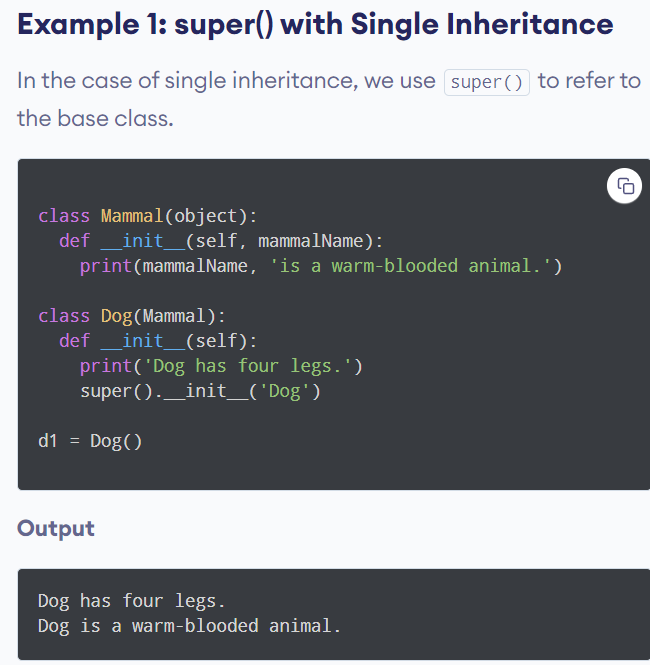

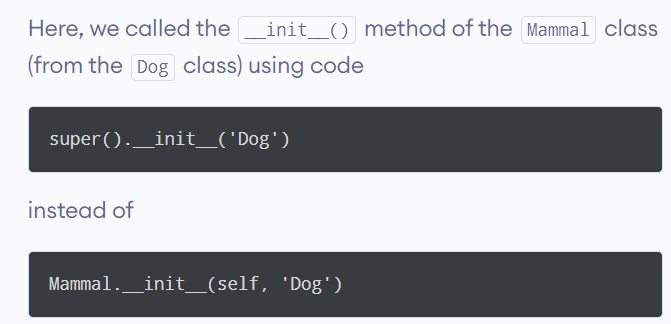

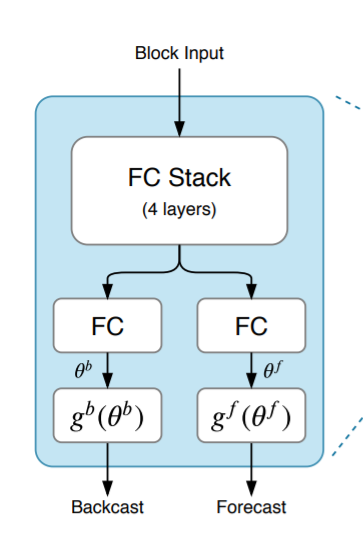

In [217]:
# Create N-BEATS Block custom layer
class NBeatsBlock(tf.keras.layers.Layer):
    def __init__(self,
                 input_size: int,
                 theta_size: int, 
                 horizon: int,
                 n_neurons: int,
                 n_layers: int,
                 **kwargs): # the **kwargs argument take care of all the argument for the parent class (input_shape, trainable, etc)
        super().__init__(**kwargs)
        self.input_size = input_size
        self.theta_size = theta_size
        self.horizon = horizon
        self.n_neurons = n_neurons
        self.n_layers = n_layers
        
        # Block contain stack of 4 fully connected layer that has ReLU activation
        self.hidden = [tf.keras.layers.Dense(n_neurons, activation='relu') for i in range(n_layers)]
        # Output of block is a theta layer with linear activation
        self.theta_layer = tf.keras.layers.Dense(theta_size, activation='linear', name='theta')
        
    def call(self, inputs):
        for layer in self.hidden:
            x = layer(inputs) # Passing the input to the FC Layer
        theta = self.theta_layer(x) # output
        # Output the backcast and forecast from theta
        backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
        return backcast, forecast

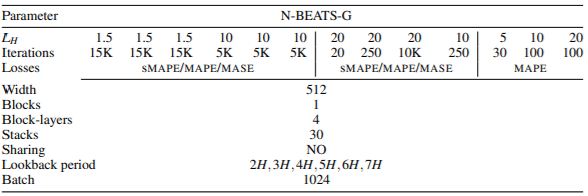

In [218]:
# Set up dummy NBeatsBlock layer
dummy_nbeats_block = NBeatsBlock(input_size=3,
                                 theta_size=3+1, 
                                 horizon=1,
                                 n_neurons=512,
                                 n_layers=4)

In [219]:
# Create dummy inputs
dummy_inputs = tf.expand_dims(tf.range(3)+1, axis=0)
dummy_inputs

<tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[1, 2, 3]])>

In [220]:
# These are the activation outputs of the theta layer 
backcast, forecast = dummy_nbeats_block(dummy_inputs)

In [221]:
backcast

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[ 0.17961541, -0.12995005,  0.1961546 ]], dtype=float32)>

In [222]:
forecast

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.03723243]], dtype=float32)>

## Set the data ready (tf.data)

In [223]:
df2_new

Price  Block_Reward       Price+1       Price+2  \
Date                                                                 
2014-11-04    324.467934         25.00           NaN           NaN   
2014-11-05    328.644408         25.00    324.467934           NaN   
2014-11-06    337.921358         25.00    328.644408    324.467934   
2014-11-07    348.992860         25.00    337.921358    328.644408   
2014-11-08    341.459753         25.00    348.992860    337.921358   
...                  ...           ...           ...           ...   
2021-12-09  50512.038512          6.25  50638.162863  50564.300000   
2021-12-10  47594.381934          6.25  50512.038512  50638.162863   
2021-12-11  47162.324050          6.25  47594.381934  50512.038512   
2021-12-12  49353.419314          6.25  47162.324050  47594.381934   
2021-12-13  50103.541821          6.25  49353.419314  47162.324050   

                 Price+3  
Date                      
2014-11-04           NaN  
2014-11-05           NaN  
2014-11-06           NaN  
2014-11-07    324.467934  
2014-11-08    328.644408  
...                  ...  
2021-12-09  49455.282036  
2021-12-10  50564.300000  
2021-12-11  50638.162863  
2021-12-12  50512.038512  
2021-12-13  47594.381934  

[2597 rows x 5 columns]

In [224]:
split_size = int(0.8 * len(full_windows_31_pd))

train_windows_31_pd = full_windows_31_pd[:split_size].astype(np.float32)
test_windows_31_pd = full_windows_31_pd[split_size:].astype(np.float32)

train_labels_31_pd = full_labels_31_pd[:split_size].astype(np.float32)
test_labels_31_pd = full_labels_31_pd[split_size:].astype(np.float32)

# train_windows_31_pd = np.expand_dims(train_windows_31_pd, axis=-1)
# test_windows_31_pd = np.expand_dims(test_windows_31_pd, axis=-1)

In [225]:
train_windows_31_pd.shape # (Batch, timesteps, ndim)

(2075, 3)

In [226]:
train_windows_31_pd

array([[ 324.46793,  328.6444 ,  337.92136],
       [ 328.6444 ,  337.92136,  348.99286],
       [ 337.92136,  348.99286,  341.45975],
       ...,
       [9346.448  , 9253.988  , 9437.699  ],
       [9253.988  , 9437.699  , 9237.455  ],
       [9437.699  , 9237.455  , 9286.942  ]], dtype=float32)

In [227]:
train_labels_31_pd

array([[ 348.99286],
       [ 341.45975],
       [ 344.7453 ],
       ...,
       [9237.455  ],
       [9286.942  ],
       [9235.144  ]], dtype=float32)

In [228]:
train_windows_31_pd = tf.data.Dataset.from_tensor_slices(train_windows_31_pd)
test_windows_31_pd = tf.data.Dataset.from_tensor_slices(test_windows_31_pd)

train_labels_31_pd = tf.data.Dataset.from_tensor_slices(train_labels_31_pd)
test_labels_31_pd = tf.data.Dataset.from_tensor_slices(test_labels_31_pd)

TRAIN_DATA = tf.data.Dataset.zip((train_windows_31_pd, train_labels_31_pd))
TEST_DATA = tf.data.Dataset.zip((test_windows_31_pd, test_labels_31_pd))

In [229]:
TRAIN_DATA

<ZipDataset shapes: ((3,), (1,)), types: (tf.float32, tf.float32)>

In [230]:
TEST_DATA

<ZipDataset shapes: ((3,), (1,)), types: (tf.float32, tf.float32)>

In [231]:
# Prefetch
TRAIN_DATA = TRAIN_DATA.batch(1024).prefetch(tf.data.AUTOTUNE)
TEST_DATA = TEST_DATA.batch(1024).prefetch(tf.data.AUTOTUNE)

In [232]:
TRAIN_DATA

<PrefetchDataset shapes: ((None, 3), (None, 1)), types: (tf.float32, tf.float32)>

## Hyperparameters for N-BEATS

In [233]:
WINDOW_SIZE = 3
HORIZON = 1

N_EPOCHS = 5000
N_NEURONS = 512
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = 3
THETA_SIZE = 4

## Residual Connection
> Before we can craft our N-BEATS model, we need two layers for the residual connections (substract and add)

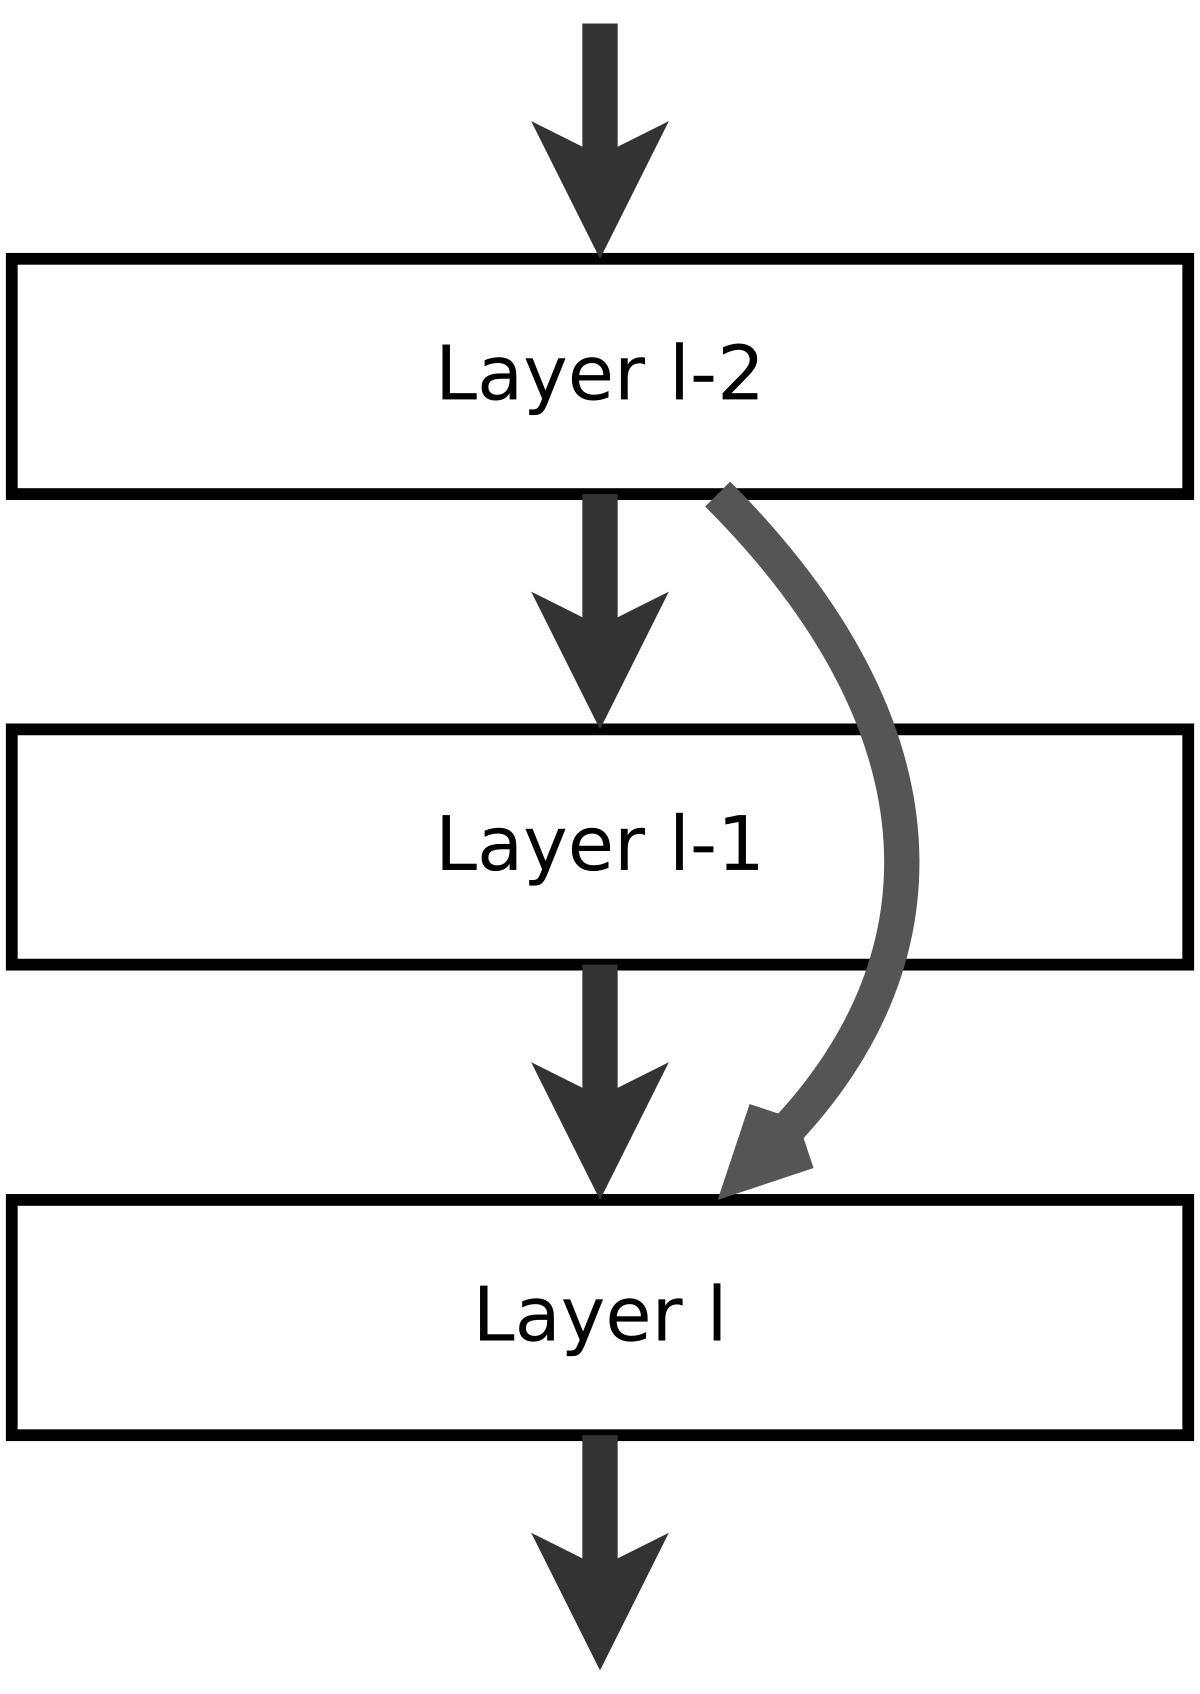

In [234]:
# Make tensor
tensor_1 = tf.range(10) + 10
tensor_2 = tf.range(10)

In [235]:
tensor_1

<tf.Tensor: shape=(10,), dtype=int32, numpy=array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19])>

In [236]:
# Substract
substracted = layers.subtract([tensor_1, tensor_2])

# Add 
added = layers.add([tensor_1, tensor_2])

In [237]:
substracted

<tf.Tensor: shape=(10,), dtype=int32, numpy=array([10, 10, 10, 10, 10, 10, 10, 10, 10, 10])>

In [238]:
added

<tf.Tensor: shape=(10,), dtype=int32, numpy=array([10, 12, 14, 16, 18, 20, 22, 24, 26, 28])>

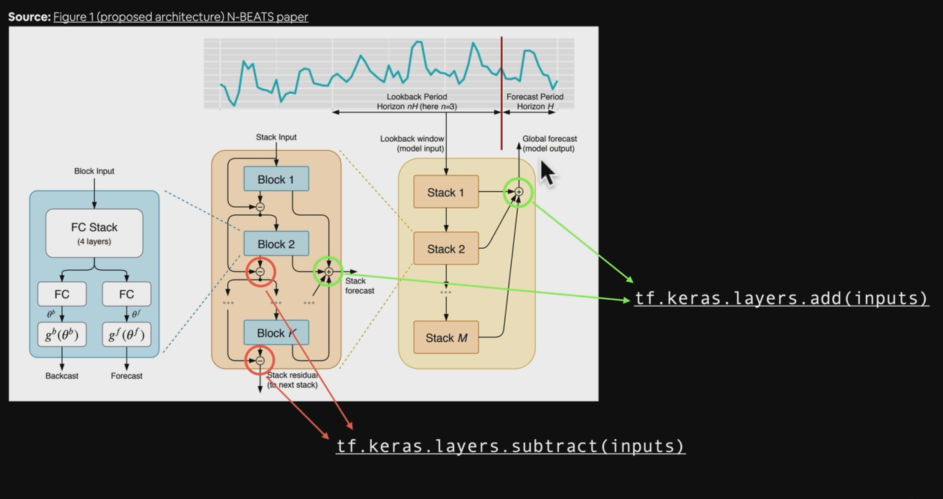

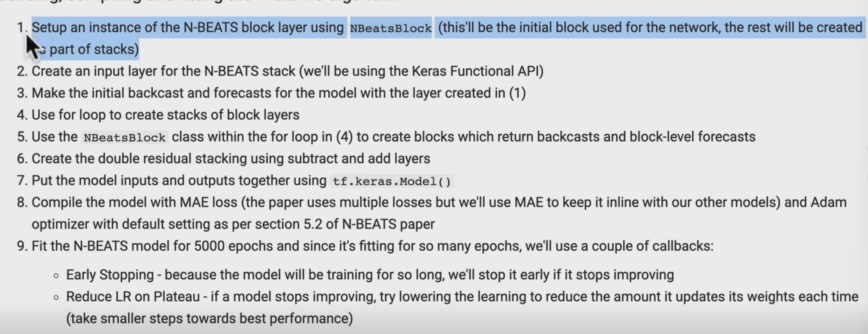

In [239]:
%%time

tf.random.set_seed(42)

# 1. Setup and instance of NBeatsBlock
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name='InitialBlock')

# 2. Create inputs to stack
stack_input = layers.Input(shape=(INPUT_SIZE), name='stack_input')

# 3. Create initial backcast (residual) and forecast
residuals, forecast = nbeats_block_layer(stack_input)

# 4. Create stacks for block layer
for i, _ in enumerate(range(N_STACKS - 1)):
    
    # 5. Use the NBeatsBlock to calculate the backcast as well as the forecast
    backcast, block_forecast = NBeatsBlock(
        input_size=INPUT_SIZE,
        theta_size=THETA_SIZE,
        horizon=HORIZON,
        n_neurons=N_NEURONS,
        n_layers=N_LAYERS,
        name=f'NBeatsBlock_{i}'
    )(residuals) # Pass in the residuals
    
    # 6. Create the double residual stacking
    residuals = layers.subtract([residuals, backcast], name=f'Substract_{i}')
    forecast = layers.add([forecast, block_forecast], name=f'Add_{i}')
    
# 7. Put the stack model 
model_7 = tf.keras.Model(inputs=stack_input, outputs=forecast, name='Model_7_NBEATS')

Wall time: 1.1 s


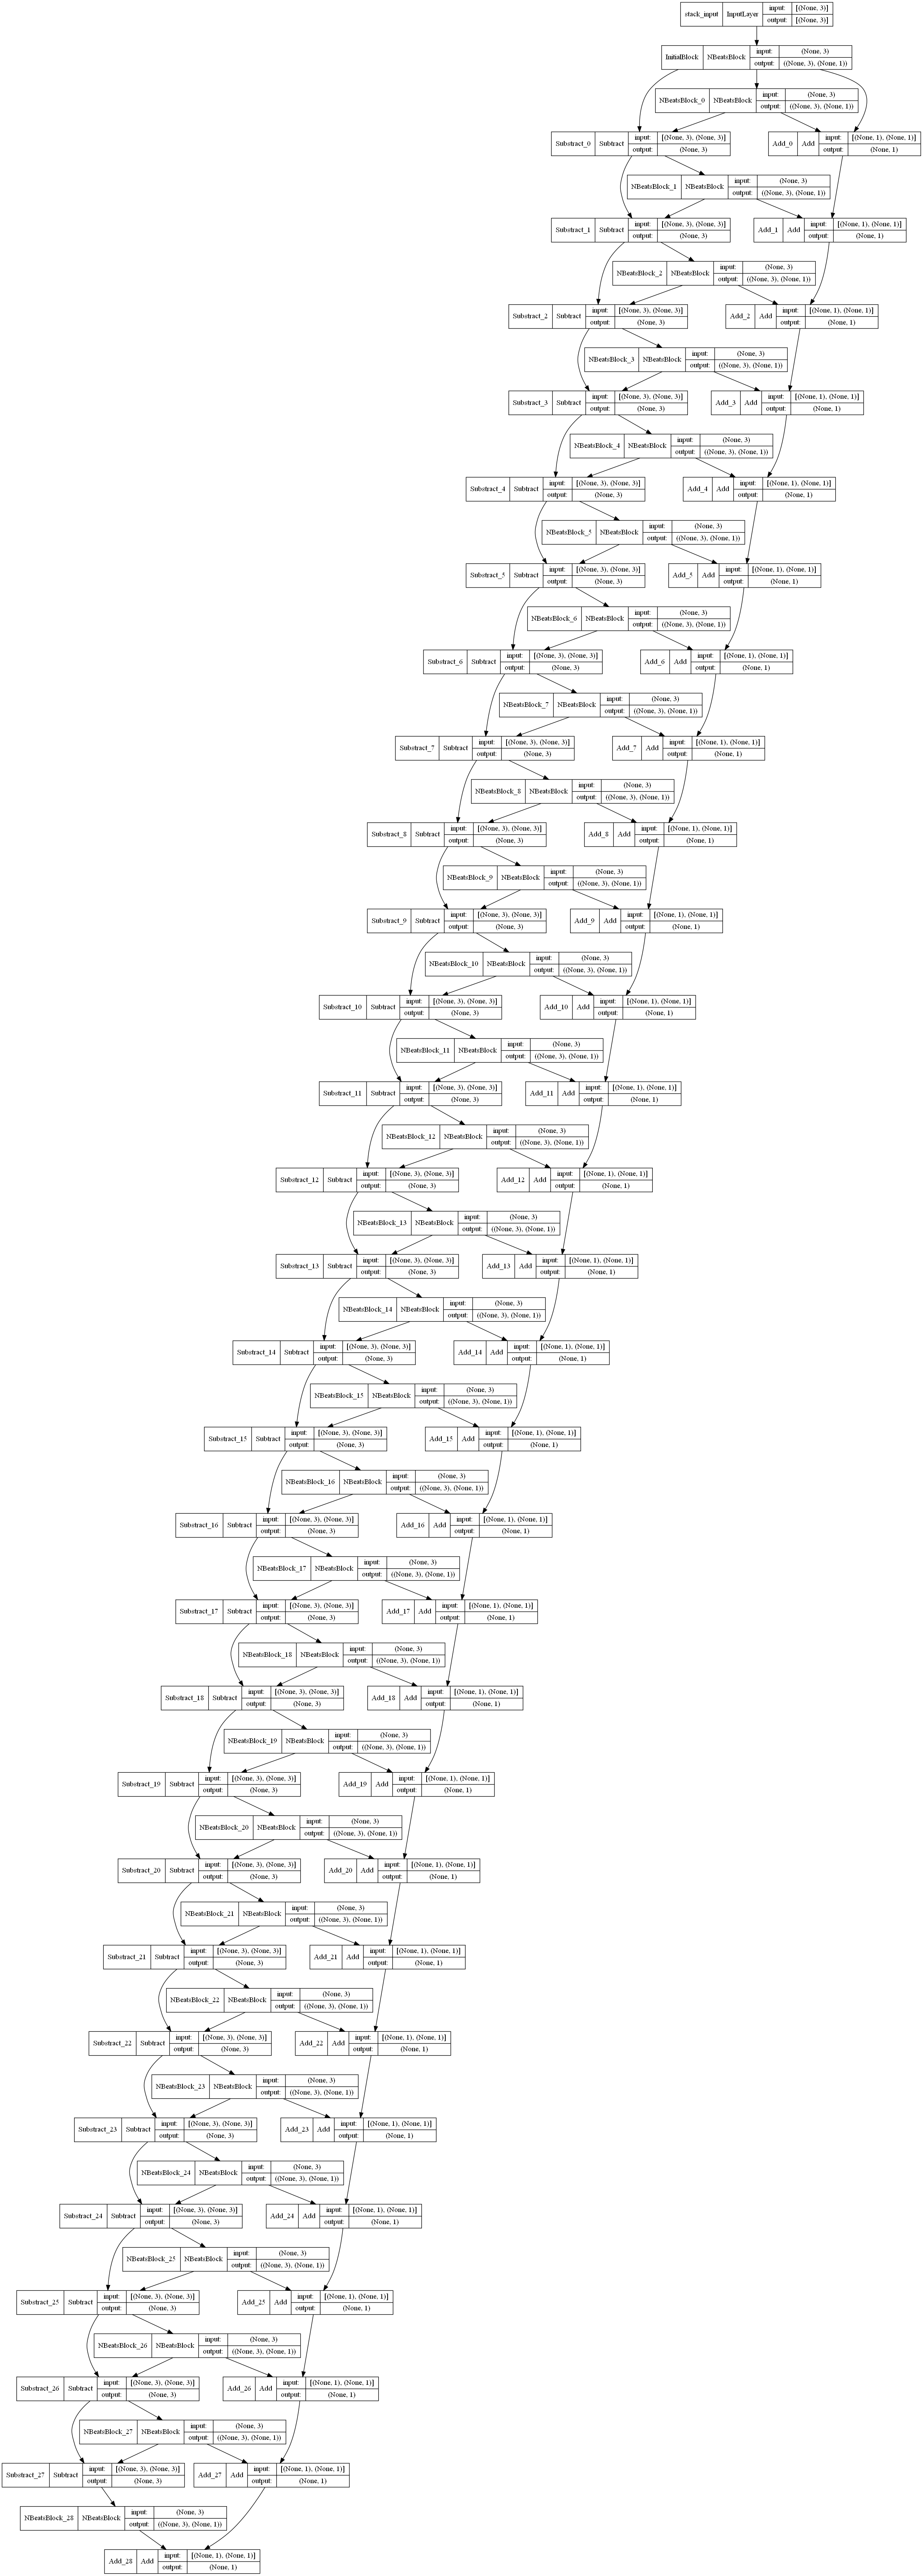

In [240]:
tf.keras.utils.plot_model(model_7, show_shapes=True)

In [241]:
# 8. Compile the model
model_7.compile(optimizer=Adam(),
                loss='mae')

In [242]:
# 9. Fit the model with EarlyStopping and ReduceLROnPlateu callbacks
model_7.fit(TRAIN_DATA,
            epochs=5000,
            validation_data=(TEST_DATA),
            verbose=1,
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                        patience=200,
                                                        restore_best_weights=True),
                       tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                            patience=100,
                                                            verbose=1)])

Epoch 1/5000
3/3 [==============================] - 6s 572ms/step - loss: 3178.8740 - val_loss: 66368.3594 - lr: 0.0010
Epoch 2/5000
3/3 [==============================] - 0s 51ms/step - loss: 15853.3115 - val_loss: 19086.6738 - lr: 0.0010
Epoch 3/5000
3/3 [==============================] - 0s 50ms/step - loss: 824.4460 - val_loss: 17256.4160 - lr: 0.0010
Epoch 4/5000
3/3 [==============================] - 0s 55ms/step - loss: 2099.1345 - val_loss: 9471.0215 - lr: 0.0010
Epoch 5/5000
3/3 [==============================] - 0s 51ms/step - loss: 296.5375 - val_loss: 8482.3457 - lr: 0.0010
Epoch 6/5000
3/3 [==============================] - 0s 49ms/step - loss: 447.1046 - val_loss: 7766.0137 - lr: 0.0010
Epoch 7/5000
3/3 [==============================] - 0s 49ms/step - loss: 1030.1224 - val_loss: 1777.4623 - lr: 0.0010
Epoch 8/5000
3/3 [==============================] - 0s 49ms/step - loss: 535.8766 - val_loss: 1256.4432 - lr: 0.0010
Epoch 9/5000
3/3 [==============================] - 0s 

In [243]:
model_7.evaluate(TEST_DATA)

1/1 [==============================] - 0s 35ms/step - loss: 1092.9642


1092.9642333984375

In [244]:
model_7_pred = model_7.predict(TEST_DATA)
model_7_pred[:10]

array([[9273.688],
       [9308.447],
       [9278.507],
       [9273.495],
       [9231.111],
       [9165.771],
       [9171.161],
       [9196.124],
       [9230.73 ],
       [9200.084]], dtype=float32)

In [245]:
test_labels_31_pd = full_labels_31_pd[split_size:].astype(np.float32)
test_labels_31_pd[:10]

array([[9299.539],
       [9236.91 ],
       [9255.128],
       [9191.484],
       [9130.441],
       [9154.164],
       [9174.642],
       [9213.238],
       [9162.424],
       [9393.385]], dtype=float32)

In [246]:
model_7_results = evaluate_preds(test_labels_31_pd, model_7_pred)
model_7_results

{'MAE': 1092.9644,
 'MSE': 2683988.2,
 'RMSE': 1638.2882,
 'MAPE': 2.8348494,
 'MASE': 1.0133959}

In [247]:
model_4_results

{'MAE': 1069.6477,
 'MSE': 2593301.8,
 'RMSE': 1610.3732,
 'MAPE': 2.78791,
 'MASE': 0.99177676}

In [248]:
naive_results

{'MAE': 1080.4816,
 'MSE': 2616088.8,
 'RMSE': 1617.4327,
 'MAPE': 2.8337994,
 'MASE': 0.99809825}

## Model 8: Ensemble Model

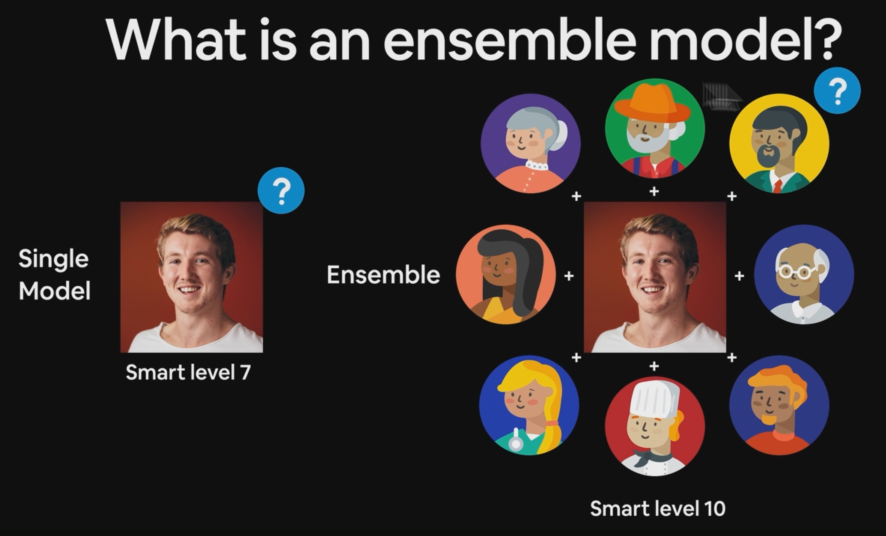

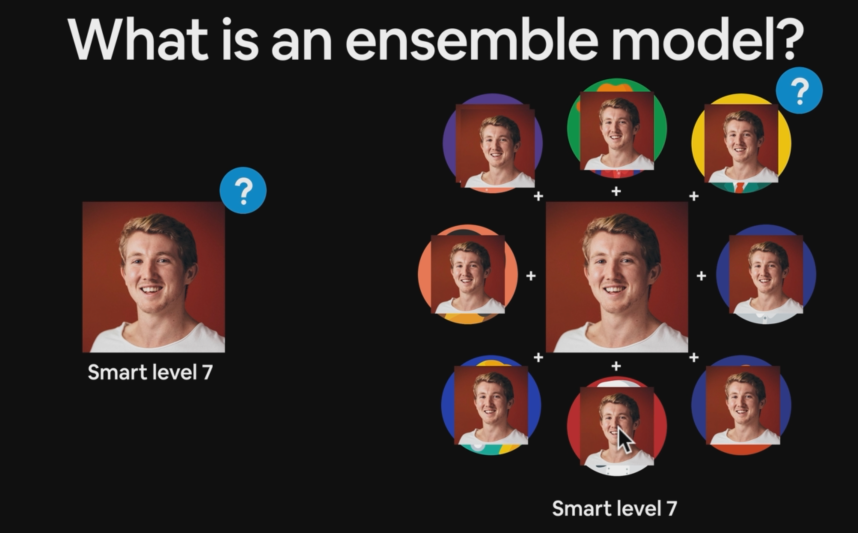

In [249]:
def get_ensamble_models(horizon=HORIZON,
                        train_data=TRAIN_DATA,
                        test_data=TEST_DATA,
                        num_iter=10,
                        num_epochs=1000,
                        loss_fn=['mae', 'mse', 'mape']):
    """
    Returns a list of num_iter models each trained on MAE, MSE, and MAPE loss
    
    For example, if num_iter=10, a ist of 30 trained models will be returned
    10 * len(['mae', 'mse', 'mape'])
    """
    
    # Make empty list for trained ensemble models
    ensemble_models = []
    
    # Create num_iter number of models per loss function
    for i in range(num_iter):
        # Build and fit new modelwith a different loss function
        for loss_function in loss_fn:
            print(f'Optimizing model by reducing: {loss_function} for {num_epochs} epochs, model number: {i}')
            
            # Construct a simple model (similar to model_4)
            model = Sequential([
                layers.Lambda(lambda x: tf.expand_dims(x, axis=-1)),
                layers.Conv1D(filters=128, kernel_size=3, activation='relu', kernel_initializer='he_normal'),
                layers.GlobalMaxPool1D(),
                layers.Dense(HORIZON, activation='linear')
            ])
            
            # Compile the model
            model.compile(loss=loss_function,
                          optimizer=Adam())
            
            # Fit the model
            model.fit(TRAIN_DATA,
                      epochs=num_epochs,
                      validation_data=TEST_DATA,
                      verbose=0,
                      callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                                 patience=200,
                                                                 restore_best_weights=True),
                                tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                                     patience=100,
                                                                     verbose=1)])
            
            # Append fitted model to list of ensemble models
            ensemble_models.append(model)
            
    return ensemble_models

In [250]:
import time
now = time.time()

ensemble_model = get_ensamble_models(num_iter=3,
                                     num_epochs=1000)
finished = time.time()
print(f'Time needed {finished - now}')

Optimizing model by reducing: mae for 1000 epochs, model number: 0

Epoch 00457: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00557: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mse for 1000 epochs, model number: 0

Epoch 00625: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00725: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mape for 1000 epochs, model number: 0

Epoch 00381: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00481: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mae for 1000 epochs, model number: 1

Epoch 00715: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00815: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mse for 1000 epochs, model number: 1

Epoch 0

In [256]:
(finished - now) / 60 # almost 4 minutes

3.803543492158254

In [257]:
ensemble_model

In [571]:
def make_ensemble_preds(ensemble_models, data):
    ensemble_preds = []
    for model in ensemble_models:
        preds = model.predict(data)
        ensemble_preds.append(preds)
    return np.median(tf.squeeze(ensemble_preds), axis=0), tf.squeeze(ensemble_preds)

In [572]:
ensemble_preds, test_preds = make_ensemble_preds(ensemble_model, TEST_DATA)
ensemble_preds = np.expand_dims(ensemble_preds, axis=-1)
ensemble_preds[0]

Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.


array([9244.202], dtype=float32)

In [573]:
np.median(test_preds[:, 0])

9244.202

In [574]:
test_labels_31_pd[:10]

array([[9299.539],
       [9236.91 ],
       [9255.128],
       [9191.484],
       [9130.441],
       [9154.164],
       [9174.642],
       [9213.238],
       [9162.424],
       [9393.385]], dtype=float32)

In [575]:
split_size = int(0.8 * len(full_windows_31_pd))

train_windows_31_pd = full_windows_31_pd[:split_size]
test_windows_31_pd = full_windows_31_pd[split_size:]

train_labels_31_pd = full_labels_31_pd[:split_size]
test_labels_31_pd = full_labels_31_pd[split_size:]

In [576]:
test_labels_31_pd = np.expand_dims(test_labels_31_pd, axis=-1)
test_labels_31_pd[:10]

array([[9299.539],
       [9236.91 ],
       [9255.128],
       [9191.484],
       [9130.441],
       [9154.164],
       [9174.642],
       [9213.238],
       [9162.424],
       [9393.385]], dtype=float32)

In [577]:
model_8_results = evaluate_preds(test_labels_31_pd, ensemble_preds)

In [578]:
model_8_results

{'MAE': 1072.9485,
 'MSE': 2588712.0,
 'RMSE': 1608.9475,
 'MAPE': 2.8000739,
 'MASE': 0.9948372}

In [263]:
model_4_results

{'MAE': 1069.6477,
 'MSE': 2593301.8,
 'RMSE': 1610.3732,
 'MAPE': 2.78791,
 'MASE': 0.99177676}

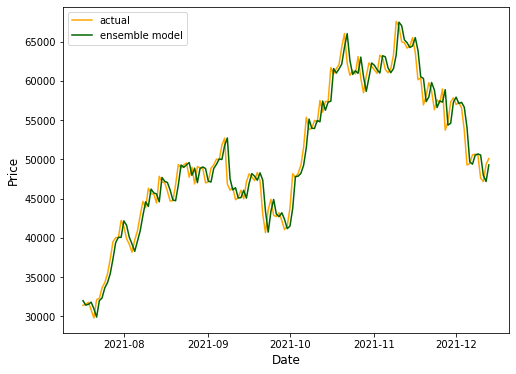

In [264]:
plt.figure(figsize=(8, 6))
plot_graph_zoomed(time_steps[-150:], test_labels_31[-150:], train_size=1, label='actual', color='orange')
plot_graph_zoomed(time_steps[-150:], ensemble_preds[-150:], train_size=1, label='ensemble model', color='darkgreen')

## Forecasting (Uncertainty Estimation)

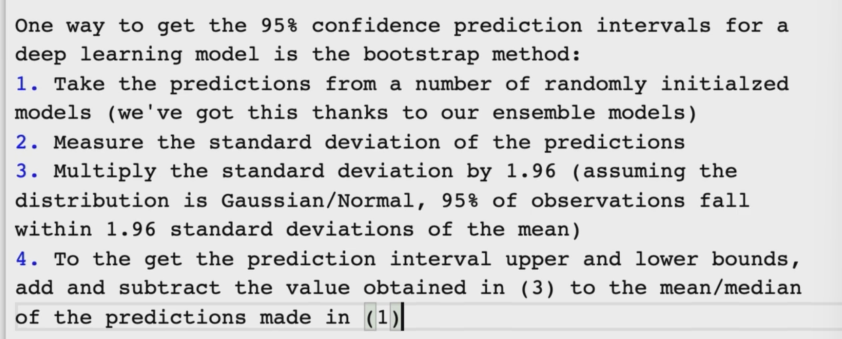

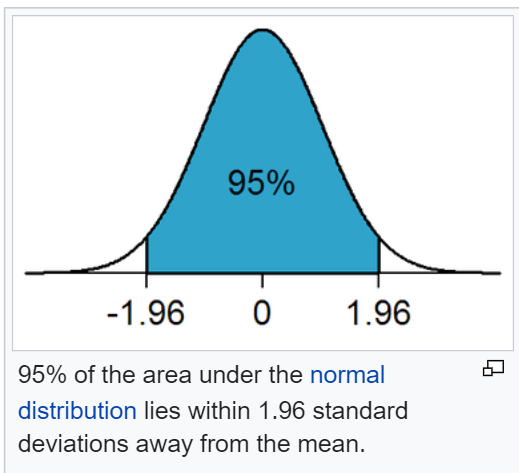

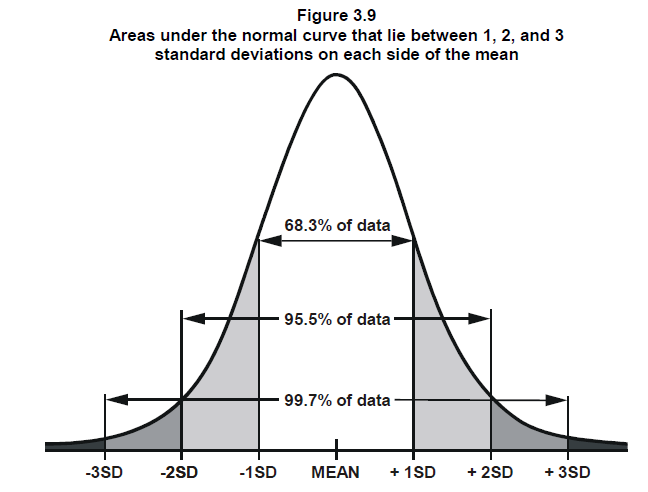

In [265]:
ensemble_preds[:10]

array([[9244.202 ],
       [9301.923 ],
       [9247.688 ],
       [9260.0205],
       [9200.863 ],
       [9136.705 ],
       [9159.207 ],
       [9182.2705],
       [9220.114 ],
       [9170.652 ]], dtype=float32)

In [266]:
test_preds[:10]

<tf.Tensor: shape=(9, 519), dtype=float32, numpy=
array([[ 9257.105,  9312.224,  9259.269, ..., 48153.312, 47222.52 ,
        49354.945],
       [ 9239.528,  9306.102,  9241.18 , ..., 47522.957, 47128.266,
        49441.746],
       [ 9264.243,  9311.232,  9267.744, ..., 48094.76 , 47275.473,
        49365.26 ],
       ...,
       [ 9220.055,  9268.918,  9223.25 , ..., 47525.836, 47010.33 ,
        48940.52 ],
       [ 9244.202,  9301.05 ,  9247.16 , ..., 47568.957, 46919.168,
        49364.316],
       [ 9252.126,  9301.923,  9255.408, ..., 47943.523, 47220.156,
        49170.31 ]], dtype=float32)>

In [267]:
tf.math.reduce_std(test_preds, axis=0)[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([12.304812, 12.652376, 12.435299, 12.594323, 12.763815, 14.603339,
       12.41211 , 11.870291, 12.083042, 12.259842], dtype=float32)>

In [268]:
# Find upper and lower bounds of ensemble predictions
def get_upper_lower(preds): # 1. Take the predictions from a number of randomly initialized
    
    # 2. Measure the standard deviation of the predictions
    std = tf.math.reduce_std(preds, axis=0)
    
    # 3. Multiply the std by 1.96 (cover 95% od all data)
    interval = std * 1.96
    
    # Upper and lower bound 
    mean = tf.math.reduce_mean(preds, axis=0)
    upper, lower = mean + interval, mean - interval
    
    return upper, lower

In [269]:
ensemble_upper, ensemble_lower = get_upper_lower(test_preds)

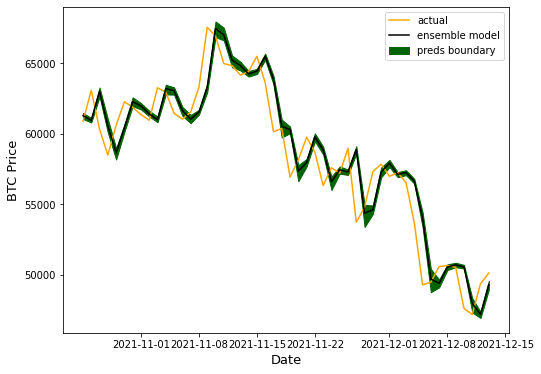

In [310]:
plt.figure(figsize=(8, 6))
plt.plot(time_steps[-50:], test_labels_31_pd[-50:], '-', color='orange', label='actual')
plt.plot(time_steps[-50:], ensemble_preds[-50:], '-', color='black', label='ensemble model')
plt.fill_between(time_steps[-50:],
                 ensemble_upper[-50:],
                 ensemble_lower[-50:],
                 color='darkgreen', label='preds boundary')
plt.xlabel('Date', fontsize=13)
plt.ylabel('BTC Price', fontsize=13)
plt.legend();

## Uncertainty

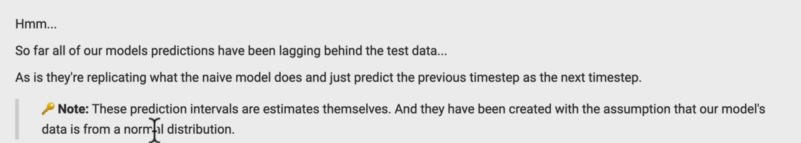

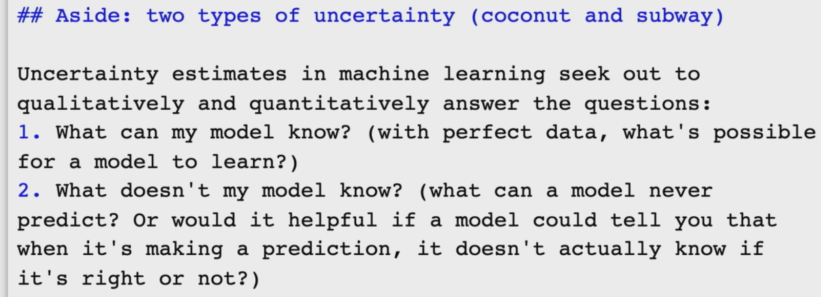

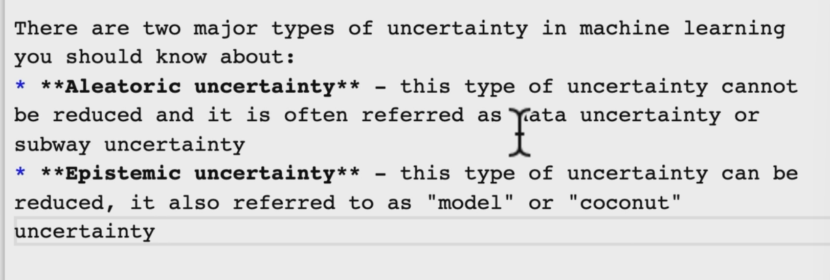

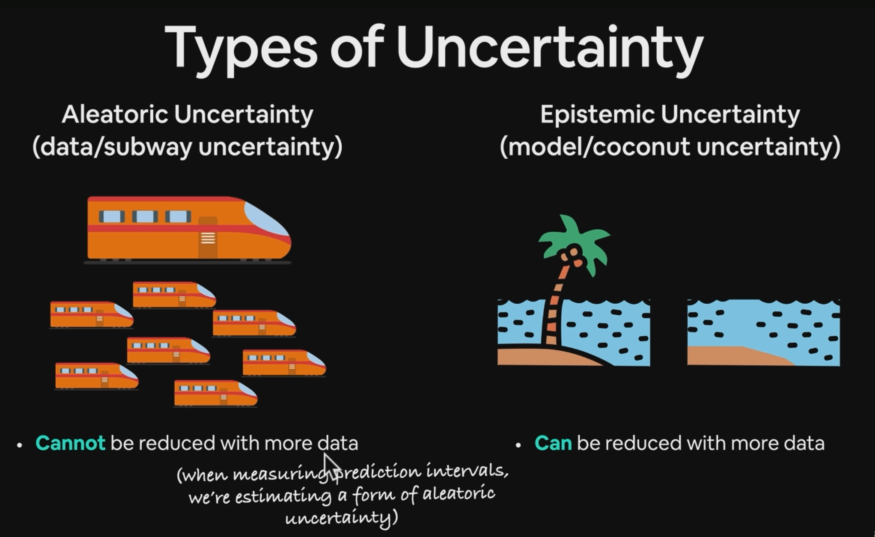

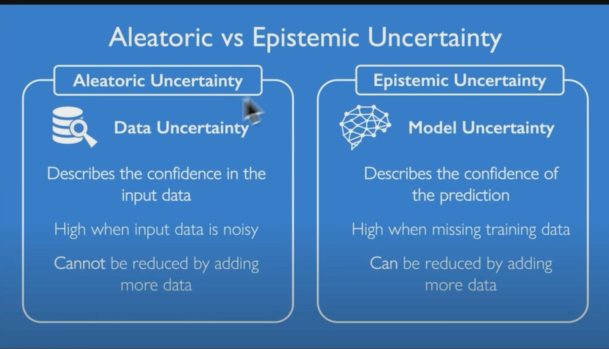

## Model 9: Model that predict future

In [427]:
full_windows_31_pd = df2_new[['Price+3', 'Price+2', 'Price+1']].to_numpy()[3:]
full_labels_31_pd = df2_new['Price'][3:].to_numpy()
full_labels_31_pd = np.expand_dims(full_labels_31_pd, axis=-1)
full_labels_31_pd = full_labels_31_pd.astype(np.float32)
full_labels_31_pd

array([[  348.99286],
       [  341.45975],
       [  344.7453 ],
       ...,
       [47162.324  ],
       [49353.418  ],
       [50103.543  ]], dtype=float32)

In [428]:
full_windows_31_pd = full_windows_31_pd.astype(np.float32)
full_labels_31_pd = full_labels_31_pd.astype(np.float32)

ALL_FEATURE = tf.data.Dataset.from_tensor_slices(full_windows_31_pd)
ALL_LABEL = tf.data.Dataset.from_tensor_slices(full_labels_31_pd)
ALL_DATA = tf.data.Dataset.zip((ALL_FEATURE, ALL_LABEL)).batch(128).prefetch(tf.data.AUTOTUNE)

In [429]:
ALL_DATA

<PrefetchDataset shapes: ((None, 3), (None, 1)), types: (tf.float32, tf.float32)>

In [481]:
# Create a model
model_9 = Sequential([
    layers.Input(shape=(3)),
    layers.Dense(256, activation='relu'),
    layers.Dense(1)
])

# Compile the model
model_9.compile(optimizer=Adam(),
                loss='mae')

# Fit the model
model_9.fit(full_windows_31_pd,
            full_labels_31_pd,
            batch_size=128,
            epochs=10,
            verbose=1)

Epoch 1/10
21/21 [==============================] - 0s 6ms/step - loss: 5552.8721
Epoch 2/10
21/21 [==============================] - 0s 6ms/step - loss: 812.1274
Epoch 3/10
21/21 [==============================] - 0s 6ms/step - loss: 486.7628
Epoch 4/10
21/21 [==============================] - 0s 5ms/step - loss: 425.8769
Epoch 5/10
21/21 [==============================] - 0s 5ms/step - loss: 409.6304
Epoch 6/10
21/21 [==============================] - 0s 6ms/step - loss: 406.2153
Epoch 7/10
21/21 [==============================] - 0s 4ms/step - loss: 398.9768
Epoch 8/10
21/21 [==============================] - 0s 3ms/step - loss: 391.0500
Epoch 9/10
21/21 [==============================] - 0s 4ms/step - loss: 419.3038
Epoch 10/10
21/21 [==============================] - 0s 4ms/step - loss: 381.8351


### Make predictions into future

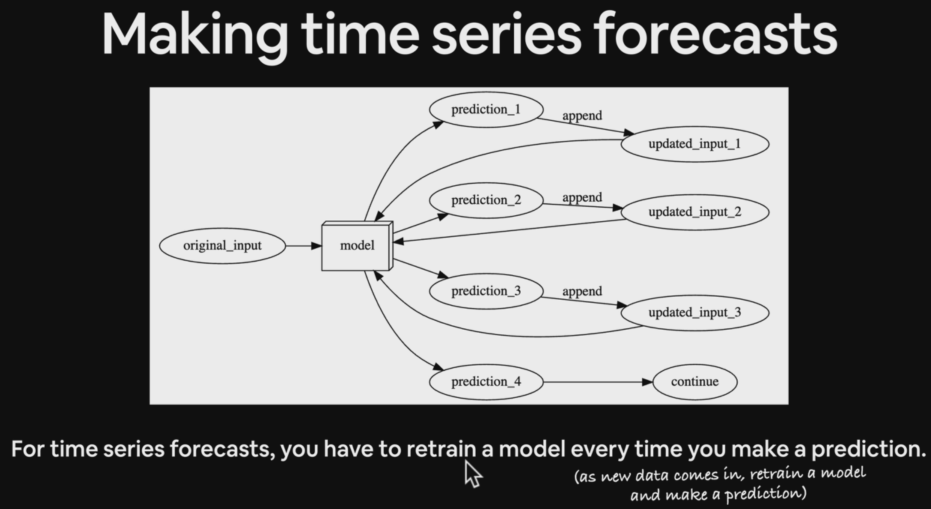

In [482]:
full_windows_31_pd[-1]

array([47594.383, 47162.324, 49353.418], dtype=float32)

In [483]:
# 1. Set how many time steps we want to predict into the future
INTO_FUTURE = 14
WINDOW_SIZE = 3

# 2. Create function to make prediction into the future
def make_future_forecast(values, model, into_future, window_size=WINDOW_SIZE) -> list: # return a list
    
    # 3. Create an empty list for forecast data
    future_forecast = []
    last_window = values[-window_size:]
    
    # 4. Make predictions
    for i in range(into_future):
        pred = model.predict(tf.expand_dims(last_window, axis=0))
        print(f'Predicting on\n {last_window} -> Prediction: {tf.squeeze(pred).numpy()}')
        
        # 5. Append predictions to future forecast
        future_forecast.append(tf.squeeze(pred).numpy())
        
        # 6. Update the last window
        last_window = np.append(last_window, tf.squeeze(pred).numpy())
        last_window = last_window[-window_size:]
        
    return future_forecast

In [484]:
full_labels_31_pd = tf.squeeze(full_labels_31_pd)
full_labels_31_pd[-3:]

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([47162.324, 49353.418, 50103.543], dtype=float32)>

In [485]:
forecast_14 = make_future_forecast(values=full_labels_31_pd,
                                   model=model_9,
                                   into_future=INTO_FUTURE,
                                   window_size=3)

Predicting on
 [47162.324 49353.418 50103.543] -> Prediction: 49211.125
Predicting on
 [49353.418 50103.543 49211.125] -> Prediction: 49569.75390625
Predicting on
 [50103.543 49211.125 49569.754] -> Prediction: 49778.9765625
Predicting on
 [49211.125 49569.754 49778.977] -> Prediction: 49697.05859375
Predicting on
 [49569.754 49778.977 49697.06 ] -> Prediction: 49805.97265625
Predicting on
 [49778.977 49697.06  49805.973] -> Prediction: 49904.1484375
Predicting on
 [49697.06  49805.973 49904.15 ] -> Prediction: 49951.9921875
Predicting on
 [49805.973 49904.15  49951.992] -> Prediction: 50028.55859375
Predicting on
 [49904.15  49951.992 50028.56 ] -> Prediction: 50105.57421875
Predicting on
 [49951.992 50028.56  50105.574] -> Prediction: 50174.12890625
Predicting on
 [50028.56  50105.574 50174.13 ] -> Prediction: 50247.0078125
Predicting on
 [50105.574 50174.13  50247.008] -> Prediction: 50320.37109375
Predicting on
 [50174.13  50247.008 50320.37 ] -> Prediction: 50392.41015625
Predicti

In [486]:
forecast_14 = np.append(full_labels_31_pd[-1], forecast_14)

In [487]:
forecast_14

array([50103.543, 49211.125, 49569.754, 49778.977, 49697.06 , 49805.973,
       49904.15 , 49951.992, 50028.56 , 50105.574, 50174.13 , 50247.008,
       50320.37 , 50392.41 , 50465.168], dtype=float32)

In [488]:
time_steps[-1]

datetime.datetime(2021, 12, 13, 0, 0)

In [489]:
next_time_steps = np.arange('2021-12-13', '2021-12-28', np.timedelta64(1, 'D'), dtype=np.datetime64)

In [490]:
next_time_steps

array(['2021-12-13', '2021-12-14', '2021-12-15', '2021-12-16',
       '2021-12-17', '2021-12-18', '2021-12-19', '2021-12-20',
       '2021-12-21', '2021-12-22', '2021-12-23', '2021-12-24',
       '2021-12-25', '2021-12-26', '2021-12-27'], dtype='datetime64[D]')

In [491]:
time_steps[-5:]

[datetime.datetime(2021, 12, 9, 0, 0),
 datetime.datetime(2021, 12, 10, 0, 0),
 datetime.datetime(2021, 12, 11, 0, 0),
 datetime.datetime(2021, 12, 12, 0, 0),
 datetime.datetime(2021, 12, 13, 0, 0)]

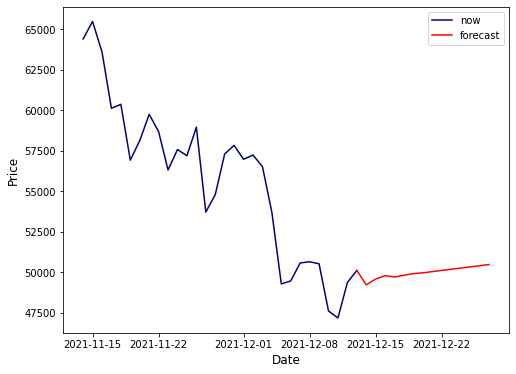

In [492]:
plt.figure(figsize=(8, 6))
plot_graph_zoomed(time_steps[-30:], full_labels_31_pd[-30:], train_size=1, label='now', color='navy')
plot_graph_zoomed(next_time_steps, forecast_14, train_size=1, color='red', label='forecast')

## Model 10: Why forecasting is BS (the turkey problem)

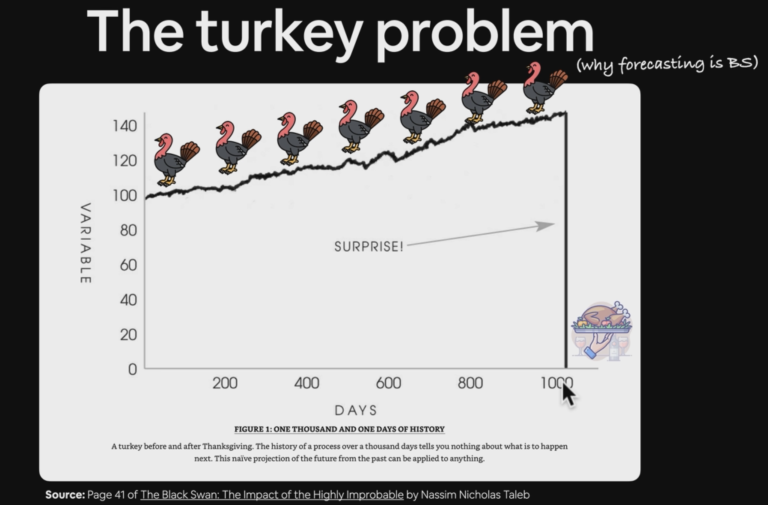

In [495]:
# Let's introduce a turkey problem to our BTC data (Price of BTC falls 100x in one day)
btc_price_turkey = btc_price.copy()
btc_price_turkey[-1] = btc_price_turkey[-1] / 100

In [496]:
btc_price_turkey[-10:]

[53694.69,
 49266.12,
 49455.282036,
 50564.3,
 50638.162863,
 50512.038512,
 47594.381934,
 47162.32405,
 49353.419314,
 501.03541821]

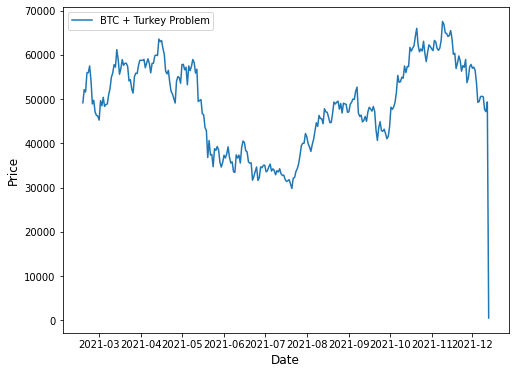

In [504]:
plt.figure(figsize=(8, 6))
plot_graph_zoomed(time_steps[-300:], btc_price_turkey[-300:], train_size=1, label='BTC + Turkey Problem')

In [507]:
df_turkey = pd.DataFrame(data={'date': time_steps,
                               'price': btc_price_turkey})

In [508]:
df_turkey

date         price
0    2014-11-04    324.467934
1    2014-11-05    328.644408
2    2014-11-06    337.921358
3    2014-11-07    348.992860
4    2014-11-08    341.459753
...         ...           ...
2592 2021-12-09  50512.038512
2593 2021-12-10  47594.381934
2594 2021-12-11  47162.324050
2595 2021-12-12  49353.419314
2596 2021-12-13    501.035418

[2597 rows x 2 columns]

In [512]:
for i in range(7):
    df_turkey[f'price_{i+1}'] = df_turkey['price'].shift(periods=i+1)

In [516]:
df_turkey = df_turkey[7:]

In [517]:
df_turkey.head()

date       price     price_1     price_2     price_3     price_4  \
7  2014-11-11  371.116917  357.239982  344.745289  341.459753  348.992860   
8  2014-11-12  366.664633  371.116917  357.239982  344.745289  341.459753   
9  2014-11-13  428.882925  366.664633  371.116917  357.239982  344.745289   
10 2014-11-14  418.944218  428.882925  366.664633  371.116917  357.239982   
11 2014-11-15  399.688315  418.944218  428.882925  366.664633  371.116917   

       price_5     price_6     price_7  
7   337.921358  328.644408  324.467934  
8   348.992860  337.921358  328.644408  
9   341.459753  348.992860  337.921358  
10  344.745289  341.459753  348.992860  
11  357.239982  344.745289  341.459753

In [518]:
df_turkey.columns

Index(['date', 'price', 'price_1', 'price_2', 'price_3', 'price_4', 'price_5',
       'price_6', 'price_7'],
      dtype='object')

In [522]:
btc_turkey_window = df_turkey[['price_7', 'price_6', 'price_5', 'price_4', 'price_3', 'price_2', 'price_1']].to_numpy().astype(np.float32)

In [525]:
btc_turkey_window

array([[  324.46793,   328.6444 ,   337.92136, ...,   341.45975,
          344.7453 ,   357.24   ],
       [  328.6444 ,   337.92136,   348.99286, ...,   344.7453 ,
          357.24   ,   371.1169 ],
       [  337.92136,   348.99286,   341.45975, ...,   357.24   ,
          371.1169 ,   366.66464],
       ...,
       [53694.69   , 49266.12   , 49455.28   , ..., 50638.164  ,
        50512.04   , 47594.383  ],
       [49266.12   , 49455.28   , 50564.3    , ..., 50512.04   ,
        47594.383  , 47162.324  ],
       [49455.28   , 50564.3    , 50638.164  , ..., 47594.383  ,
        47162.324  , 49353.418  ]], dtype=float32)

In [527]:
btc_turkey_label = df_turkey['price'].to_numpy()
btc_turkey_label = np.expand_dims(btc_turkey_label, axis=-1)
btc_turkey_label

array([[  371.116917  ],
       [  366.664633  ],
       [  428.882925  ],
       ...,
       [47162.32405   ],
       [49353.419314  ],
       [  501.03541821]])

In [528]:
split_size = int(0.8 * len(btc_turkey_window))

train_btc_turkey_window, test_btc_turkey_window = btc_turkey_window[:split_size], btc_turkey_window[split_size:]

train_btc_turkey_label, test_btc_turkey_label = btc_turkey_label[:split_size], btc_turkey_label[split_size:]

In [529]:
test_btc_turkey_window[-1]

array([49455.28 , 50564.3  , 50638.164, 50512.04 , 47594.383, 47162.324,
       49353.418], dtype=float32)

In [530]:
test_btc_turkey_label[-1]

array([501.03541821])

In [531]:
# Load turkey_model
turkey_model = load_model('BTC_Model/model_1')

In [532]:
turkey_model.compile(loss='mae',
                    optimizer=Adam())

In [533]:
turkey_model.fit(train_btc_turkey_window,
                 train_btc_turkey_label,
                 validation_data=(test_btc_turkey_window, test_btc_turkey_label),
                 epochs=100,
                 batch_size=128,
                 verbose=0,
                 callbacks=make_checkpoint('model_turkey'))


Epoch 00001: val_loss improved from inf to 1471.25952, saving model to BTC_Model\model_turkey
INFO:tensorflow:Assets written to: BTC_Model\model_turkey\assets

Epoch 00002: val_loss improved from 1471.25952 to 1172.23315, saving model to BTC_Model\model_turkey
INFO:tensorflow:Assets written to: BTC_Model\model_turkey\assets

Epoch 00003: val_loss did not improve from 1172.23315

Epoch 00004: val_loss did not improve from 1172.23315

Epoch 00005: val_loss did not improve from 1172.23315

Epoch 00006: val_loss did not improve from 1172.23315

Epoch 00007: val_loss did not improve from 1172.23315

Epoch 00008: val_loss did not improve from 1172.23315

Epoch 00009: val_loss did not improve from 1172.23315

Epoch 00010: val_loss did not improve from 1172.23315

Epoch 00011: val_loss did not improve from 1172.23315

Epoch 00012: val_loss did not improve from 1172.23315

Epoch 00013: val_loss did not improve from 1172.23315

Epoch 00014: val_loss did not improve from 1172.23315

Epoch 00015:

In [534]:
model_turkey = load_model('BTC_Model/model_turkey/')

In [535]:
model_turkey.evaluate(test_btc_turkey_window, test_btc_turkey_label)

17/17 [==============================] - 0s 2ms/step - loss: 1168.9686


1168.9686279296875

In [536]:
model_turkey_pred = model_turkey.predict(test_btc_turkey_window)

In [537]:
model_turkey_pred[:10]

array([[9305.655],
       [9244.74 ],
       [9263.707],
       [9201.325],
       [9143.155],
       [9153.815],
       [9179.487],
       [9217.497],
       [9175.321],
       [9383.127]], dtype=float32)

In [541]:
test_btc_turkey_label[:10]

array([[9236.91    ],
       [9255.128114],
       [9191.484156],
       [9130.44172 ],
       [9154.163861],
       [9174.642023],
       [9213.238584],
       [9162.423377],
       [9393.385193],
       [9537.23    ]])

In [538]:
model_turkey_results = evaluate_preds(test_btc_turkey_label, model_turkey_pred)

In [539]:
model_turkey_results

{'MAE': 1168.9686,
 'MSE': 7159884.0,
 'RMSE': 2675.796,
 'MAPE': 2.9885962,
 'MASE': 0.9961193}

In [550]:
time_steps = np.squeeze(time_steps)
time_steps[:10]

array([datetime.datetime(2014, 11, 4, 0, 0),
       datetime.datetime(2014, 11, 5, 0, 0),
       datetime.datetime(2014, 11, 6, 0, 0),
       datetime.datetime(2014, 11, 7, 0, 0),
       datetime.datetime(2014, 11, 8, 0, 0),
       datetime.datetime(2014, 11, 9, 0, 0),
       datetime.datetime(2014, 11, 10, 0, 0),
       datetime.datetime(2014, 11, 11, 0, 0),
       datetime.datetime(2014, 11, 12, 0, 0),
       datetime.datetime(2014, 11, 13, 0, 0)], dtype=object)

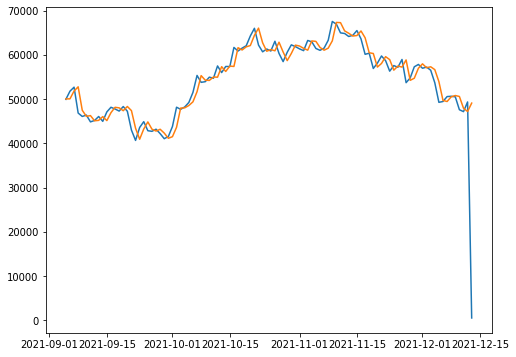

In [558]:
plt.figure(figsize=(8, 6))
plt.plot(df_turkey['date'][split_size:].to_numpy()[-100:], test_btc_turkey_label[-100:])
plt.plot(df_turkey['date'][split_size:].to_numpy()[-100:], model_turkey_pred[-100:]);

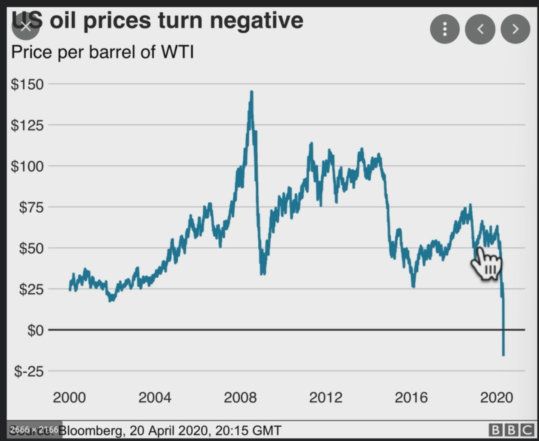

In [593]:
model_result = pd.DataFrame({'naive_model':naive_results,
                             'model_1_dense_w7_h1':model_1_result,
                             'model_2_dense_w30_h1':model_2_results,
                             'model_3_dense_w30_h7':model_3_results,
                             'model_3b_dense_w3_h1':model_3b_results,
                             'model_4_conv1d_w3_h1':model_4_results,
                             'model_5_lstm_w3_h1':model_5_results,
                             'model_6_multivariate_w3_h1':model_6_results,
                             'model_7_NBEATS_w3_h1': model_7_results,
                             'model_8_ensemble_w3_h1':model_8_results,
                             'model_10_turkey_w3_h1':model_turkey_results}).T

In [594]:
model_result = model_result.sort_values('MAE')

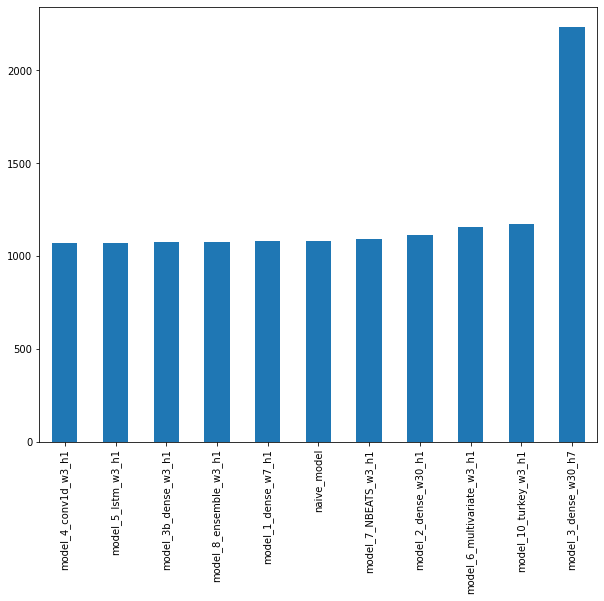

In [598]:
model_result['MAE'].plot(kind='bar', figsize=(10, 8));

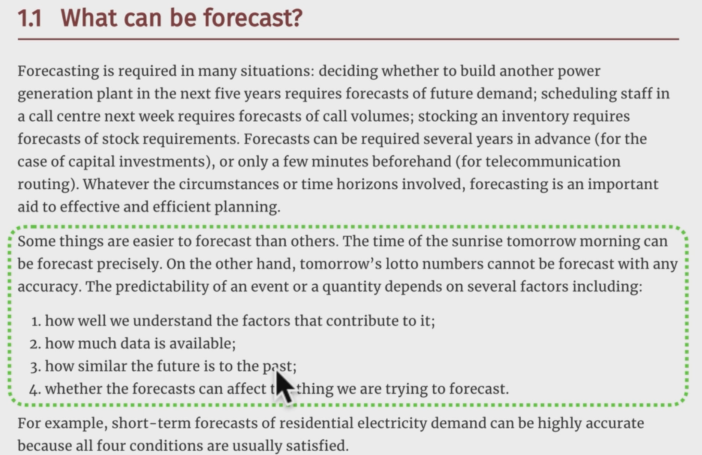